# Set overall settings

In [11]:
# Import packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pickle
import math as math
from matplotlib import gridspec
import os
import seaborn as sns
%matplotlib inline
import pandas as pd
from scipy import stats
from itertools import groupby
from operator import itemgetter
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D

In [12]:
#Set figure style
from matplotlib import rc
%matplotlib inline
plt.style.use("seaborn-white")
# plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['axes.titlesize'] = 9
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['legend.fontsize'] = 7
# plt.rcParams['lines.markeredgewidth'] = 0
plt.rcParams['font.family'] = ['sans-serif']
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]
plt.rcParams["figure.dpi"] = 200
plt.rcParams['grid.color'] = 'None'
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['xtick.major.size'] = 3.5
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.major.size'] = 3.5
plt.rcParams['ytick.minor.size'] = 2

In [48]:
# Set color scheme to match figure
fig3 = ["#5391B3","#3B8E6D","#939598", "#B492B1", "#BD9F8D","#9BB9CF", "#8FCC96", "#AADBDC"]
sns.set_palette(fig3)
# sns.palplot(sns.color_palette())

In [14]:
# Load model functions
def signal_periodic(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p/2)*slope_on < 1:
        maxs = (p/2)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        it = math.floor(t/signal_number)
        if t>=it*p and t < it*p+p/2:
            if t >= it*p and t < it*p+(1/slope_on):
                return ((t-it*p)*slope_on)
            else:
                return 1
        else:
            return 0
def signal_single(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p)*slope_on < 1:
        maxs = (p)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        if t < p:
            if t <= p and t < (1/slope_on):
                return ((t)*slope_on)
            else:
                return 1
        else:
            return 0
            
def DE_periodic(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_periodic(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def DE_single(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_single(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def simulate_periodic_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff1,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_periodic, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes
def simulate_singlepulse_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff1,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_single, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes

# Figure 3

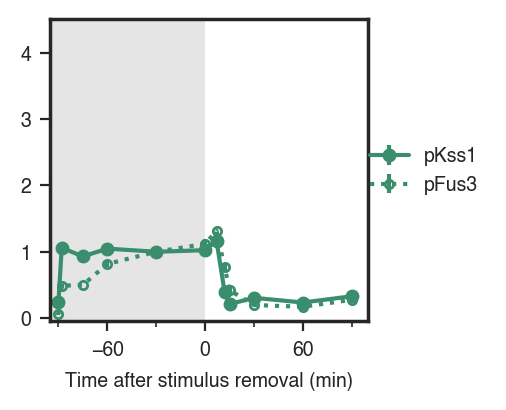

In [15]:
# plot
ppKss1 = np.array([0.21,0.90,0.79,0.89,0.85,0.87,0.99,0.33,0.18,0.26,0.20,0.28])*(1/0.85)
ppFus3 = np.array([0.05,0.37,0.38,0.62,0.76,0.85,1.00,0.58,0.32,0.15,0.13,0.21])*(1/0.76)
GFP = [0.05,0.07,0.14,0.34,0.51,0.89,0.90,0.96,0.98,0.97,0.72,0.56]
err_Kss1 = np.array([0.03,0.04,0.05,0.07,0.03,0.04,0.01,0.00,0.00,0.02,0.05,0.04])*(1/0.85)
err_Fus3 = np.array([0.01,0.02,0.00,0.04,0.06,0.06,0.00,0.04,0.04,0.01,0.02,0.03])*(1/0.76)
err_GFP = [0.00,0.01,0.03,0.05,0.11,0.07,0.06,0.04,0.01,0.02,0.02,0.03]
time = [0-90,2-90,15-90,30-90,60-90,90-90,97-90,102-90,105-90,120-90,150-90,180-90]
fig, ax = plt.subplots(figsize=(2.05,2.0))
plt.errorbar(time,ppKss1,err_Kss1,color='#3B8E6D',marker='o',markersize=4,capthick=1)
plt.errorbar(time,ppFus3,err_Fus3,color='#3B8E6D',marker='o',markersize=3,linestyle=':',markerfacecolor='None',markeredgewidth=1,markeredgecolor = '#3B8E6D',capthick=1)
# plt.errorbar(time,GFP,err_GFP,color='#8FCC96',marker='o',markersize=4,capthick=1)
plt.xlabel('Time after stimulus removal (min)')
plt.xlim([-95,100])
plt.ylim([-0.05,4.5])
lgd = plt.legend(['pKss1','pFus3','GFP'],loc='center left', bbox_to_anchor=(0.95, 0.5),ncol=1,fontsize = 7)
plt.fill_between([-95,0], -5, 4.5, facecolor='gray', alpha=0.2)
ax.xaxis.set_major_locator(plt.MultipleLocator(60))
ax.xaxis.set_minor_locator(plt.MultipleLocator(30))
plt.savefig('3B.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

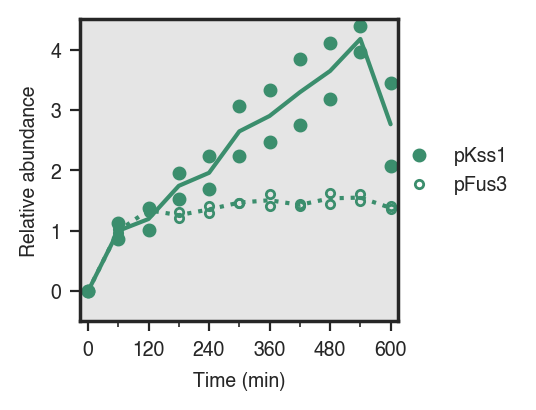

In [16]:
# plot
ppKss1 = np.array([0.00,0.22,0.35,0.39,0.57,0.57,0.63,0.70,0.81,1.12,0.53])*(1/0.255)
ppFus3 = np.array([0.00,0.82,1.09,1.03,1.12,1.16,1.11,1.14,1.29,1.27,1.07])*(1/0.79)
GFP = [0.03,1.67,2.17,1.77,1.72,1.56,1.10,1.01,0.79,0.70,0.44]
ppKss1_2 = np.array([0.00,0.29,0.26,0.50,0.43,0.78,0.85,0.98,1.05,1.01,0.88])*(1/0.255)
ppFus3_2 = np.array([0.00,0.76,1.03,0.96,1.02,1.16,1.27,1.12,1.14,1.18,1.11])*(1/0.79)
GFP_2 = [0.04,1.57,2.11,1.76,1.62,1.34,1.12,1.06,0.75,0.80,0.44]
time = [0,60,120,180,240,300,360,420,480,540,600]
Kss1_avg = []
Fus3_avg = []
GFP_avg = []
for i in range(len(time)):
    Kss1_avg.append((ppKss1[i]+ppKss1_2[i])/2)
    Fus3_avg.append((ppFus3[i]+ppFus3_2[i])/2)
    GFP_avg.append((GFP[i]+GFP_2[i])/2)
fig, ax = plt.subplots(figsize=(2.05,2.0))
plt.plot(time,[i for i in ppKss1],color='#3B8E6D',marker='o',markersize=4,linestyle='')
plt.plot(time,[i for i in ppFus3],color='#3B8E6D',marker='o',markersize=3,linestyle='',markerfacecolor='None',markeredgewidth=1,markeredgecolor = '#3B8E6D')
# plt.plot(time,[i / max(GFP_avg) for i in GFP],color='#8FCC96',marker='o',markersize=4,linestyle='')
plt.plot(time,[i for i in ppKss1_2],color='#3B8E6D',marker='o',markersize=4,linestyle='')
plt.plot(time,[i for i in ppFus3_2],color='#3B8E6D',marker='o',markersize=3,linestyle='',markerfacecolor='None',markeredgewidth=1,markeredgecolor = '#3B8E6D')
# plt.plot(time,[i / max(GFP_avg) for i in GFP_2],color='#8FCC96',marker='o',markersize=4,linestyle='')
plt.plot(time,[i for i in Kss1_avg],color='#3B8E6D',marker='',markersize=4)
plt.plot(time,[i for i in Fus3_avg],color='#3B8E6D',marker='',markersize=4,linestyle=':')
# plt.plot(time,[i / max(GFP_avg) for i in GFP_avg],color='#8FCC96',marker='',markersize=4)
plt.xlabel('Time (min)')
plt.ylabel('Relative abundance')
plt.xlim([-15,615])
plt.ylim([-0.5,4.5])
lgd = plt.legend(['pKss1','pFus3'],loc='center left', bbox_to_anchor=(0.95, 0.5),ncol=1, fontsize = 7)
plt.fill_between([-15,615], -5, 4.5, facecolor='gray', alpha=0.2)
ax.xaxis.set_major_locator(plt.MultipleLocator(120))
ax.xaxis.set_minor_locator(plt.MultipleLocator(60))
plt.savefig('3A.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

# Figure 2
## Figure 2C

In [17]:
# All data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/experimental_v2.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    experimental = pickle.load(f)
times_50constant, data_50constant, times_50pulse, data_50pulse, times_50periodic, data_50periodic, times_10periodic, data_10periodic, times_mutpulse, data_mutpulse = experimental

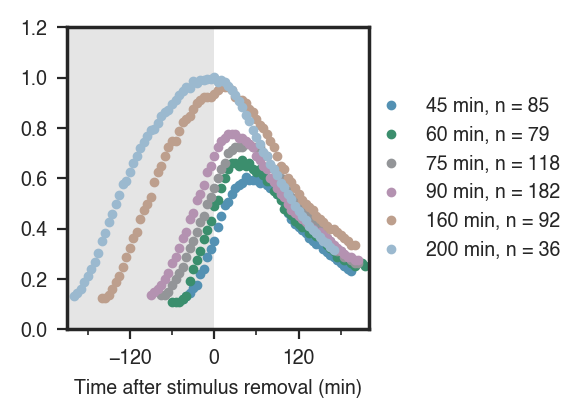

In [49]:
# plot
fig, ax = plt.subplots(figsize=(1.95,2.0))
dur = [45,60,75,90,160,200]
for i in [0,1,2,3,4,5]:
    plt.plot(times_50pulse[i]-dur[i],data_50pulse[i],marker='o',markersize=2.5,linestyle='None')
# plt.xlabel('Time after stimulus removal (min)')
plt.fill_between([-210,0], -5, 1.2, facecolor='gray', alpha=0.2)
plt.xlim([-210,220])
plt.ylim([0,1.2])
lgd = plt.legend(['45 min, n = 85','60 min, n = 79','75 min, n = 118', '90 min, n = 182', '160 min, n = 92', '200 min, n = 36'],loc='center left', bbox_to_anchor=(0.95, 0.5),ncol=1,fontsize=7)
ax.xaxis.set_major_locator(plt.MultipleLocator(120))
ax.xaxis.set_minor_locator(plt.MultipleLocator(60))
plt.xlabel('Time after stimulus removal (min)')
plt.savefig('2C.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

## Figure 2B

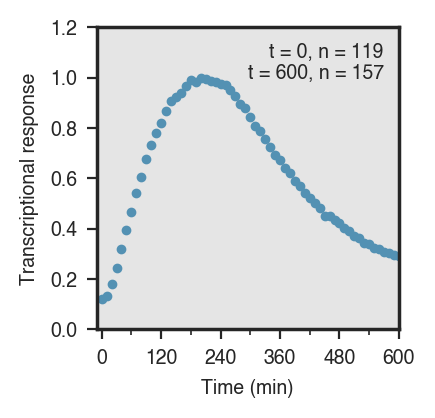

In [50]:
# plot
fig, ax = plt.subplots(figsize=(1.95,2.0))
all_axes = [ax]
for i, label in enumerate((['t = 0, n = 119'])):
    ax_curr = all_axes[i]
    ax_curr.text(.95,.95,label, transform=ax_curr.transAxes,
      fontsize=7, va='top', ha='right')
for i, label in enumerate((['t = 600, n = 157'])):
    ax_curr = all_axes[i]
    ax_curr.text(.95,.88,label, transform=ax_curr.transAxes,
      fontsize=7, va='top', ha='right')
plt.plot(times_50constant[0],data_50constant[0],marker='o',markersize=2.5,linestyle='None')
# plt.plot(times_50constant[2],data_50constant[2],marker='o',markersize=2.5,linestyle='None')
# plt.plot(times_50constant[1],data_50constant[1],marker='o',markersize=2.5,linestyle='None')
# plt.xlabel('Time (min)')
plt.fill_between([-10,660], -5, 1.2, facecolor='gray', alpha=0.2)
plt.xlim([-10,600])
plt.ylim([0,1.2])
plt.ylabel('Transcriptional response')
plt.xlabel('Time (min)')
# lgd = plt.legend(['$wildtype$'],loc='center left', bbox_to_anchor=(0.95, 0.5),ncol=1)
ax.xaxis.set_major_locator(plt.MultipleLocator(120))
ax.xaxis.set_minor_locator(plt.MultipleLocator(60))
plt.savefig('2B.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

# Figure S2

In [20]:
# Function to load data
def load_data(dir_path_data, score_cutoff):
    #MSE threshold score at which to not include 
    val_to_keep_end_score = score_cutoff
    
    #load new data:
    arr_best_scores = []
    arr_best_inds = []
    arr_end_scores = []
    dir_to_check = dir_path_data #'/home/iammoresentient/phd_lab/170307_data_sin_y1'
    files = os.listdir(dir_to_check)
    for i in range(0,len(files)):
        filename = dir_to_check + '/' + files[i]
        if os.path.isfile(filename):
            if os.path.getsize(filename) > 0: 
                if '.pickled' in files[i]:
                    #print(filename)
                    arr_to_unpickle = pickle.load(open(filename,'rb'))
                    arr_best_score, arr_best_ind = arr_to_unpickle
                    temp_end_score = arr_best_score[-1]
                    if temp_end_score < val_to_keep_end_score:
                        arr_end_scores.append(temp_end_score)
                        arr_best_scores.append(arr_best_score)
                        arr_best_inds.append(arr_best_ind)


    print('Loaded ' + str(len(arr_best_scores)) + ' files (out of ' + str(len(files)) + ') with cutoff score of ' + str(score_cutoff))

    #convert to numpy
    arr_best_scores = np.asarray(arr_best_scores)
    arr_best_inds = np.asarray(arr_best_inds)
    arr_end_scores = np.asarray(arr_end_scores)

    return arr_best_scores, arr_end_scores, arr_best_inds

In [21]:
# Simple linear model functions
def signal(signal_number,t,slope_on,slope_off):
    p = signal_number
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        if t < p:
            return 1
        else:
            return 0
def DE(y,t,signal_number,slope_on,slope_off,params):
    k1, k2, k3, d1, d2, d3, d4 = params
    X1,X2,X3,X4 = y
        
    s=signal(signal_number,t,slope_on,slope_off)
        
    # X1
    dX1dt = s-d1*X1
    # X2
    dX2dt = k1*X1-d2*X2
    # X3
    dX3dt = k2*X2-d3*X3
    # X4
    dX4dt = k3*X3-d4*X4
        
    return [dX1dt,dX2dt,dX3dt,dX4dt]
            
def simulate_single_experiment1(time,k1, k2, k3, d1, d2, d3, d4):
    params = [k1, k2, k3, d1, d2, d3, d4]
    signal_val = 200
    SS = [0,0,0,0]
    norm = np.repeat(0.127, len(time))
    # parameters to be learned
    #solve odes:
    odes = odeint(DE, SS, time, args=(signal_val,1,1,params,))
    # return array of individual cell counts:
    return odes[:,3]+norm

def simulate_single_experiment_vary(time,k1, k2, k3, d1, d2, d3, d4,signal_val):
    params = [k1, k2, k3, d1, d2, d3, d4]
    SS = [0,0,0,0]
    norm = np.repeat(0.127, len(time))
    # parameters to be learned
    #solve odes:
    odes = odeint(DE, SS, time, args=(signal_val,1,1,params,))
    # return array of individual cell counts:
    return odes[:,3]+norm

In [22]:
# Optimize
from scipy.optimize import curve_fit
fit_t = np.hstack(times_50pulse[5][0:41])
fit_y = np.hstack(data_50pulse[5][0:41])
popt, pcov = curve_fit(simulate_single_experiment1, fit_t, fit_y)
# plt.plot(fit_t,simulate_single_experiment1(fit_t,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6]))

/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in double_scalars
/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


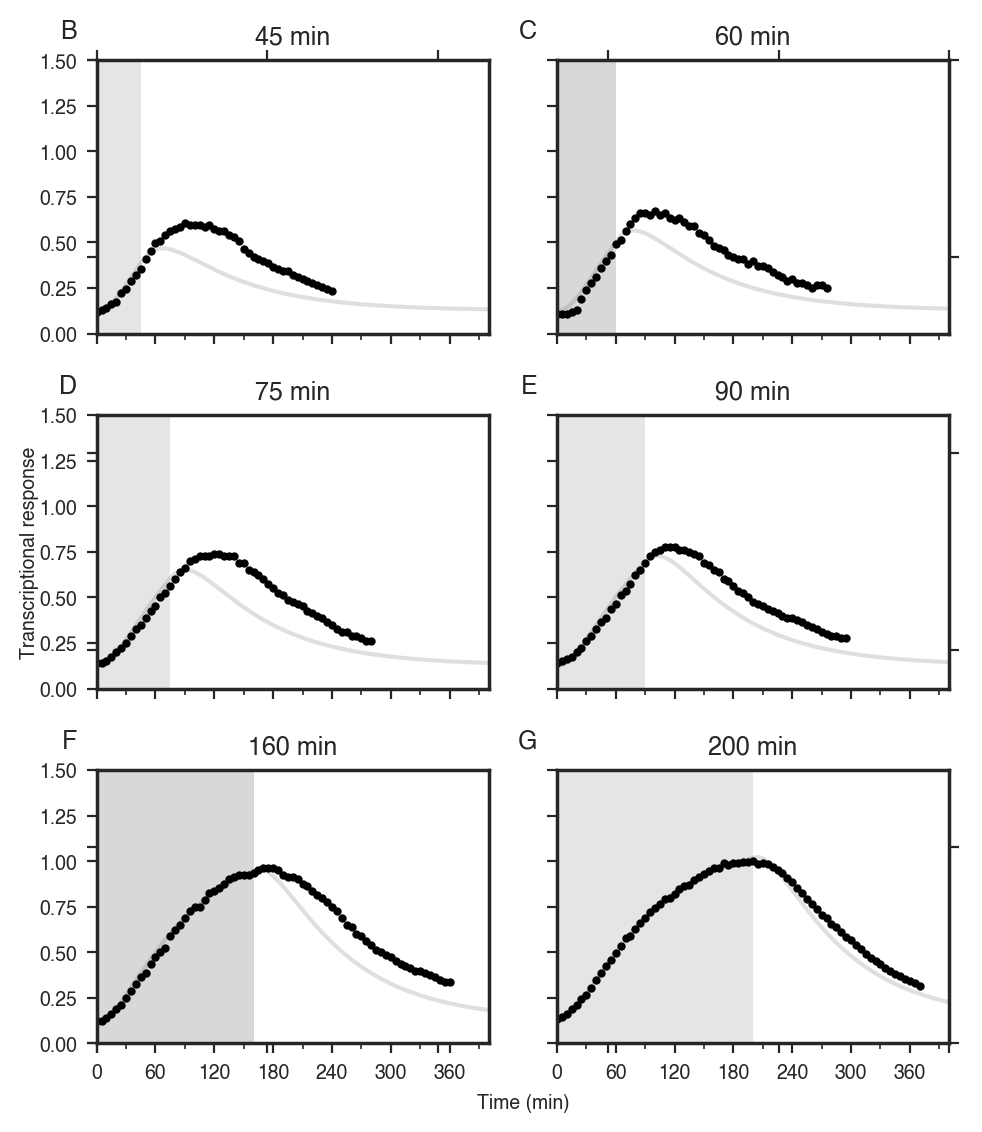

In [23]:
# Plot figure
fig = plt.figure(figsize=(5.3, 6))
gs = gridspec.GridSpec(3,2)
A = fig.add_subplot(gs[0,0])
B = fig.add_subplot(gs[0,1])
C = fig.add_subplot(gs[1,0])
D = fig.add_subplot(gs[1,1])
E = fig.add_subplot(gs[2,0])
F = fig.add_subplot(gs[2,1])
ax = fig.add_subplot(gs[:,:])

all_axes = [A,B,C,D,E,F]

for i in [A,B,C,D,E,F]:
    i.xaxis.set_major_locator(plt.MultipleLocator(60))
    i.xaxis.set_minor_locator(plt.MultipleLocator(30))

for i, label in enumerate(('B', 'C', 'D', 'E', 'F', 'G')):
    ax_curr = all_axes[i]
    ax_curr.text(-0.05, 1.15, label, transform=ax_curr.transAxes,
      fontsize=9, va='top', ha='right')

# remove figure markings
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.grid('off')

#DEFINE STEADY STATE - WT

gen = 100
IC = [0,0,0,0]
t  = np.linspace(0,40000,100001)
t1 = np.linspace(0,400,4000)


for i in [45,60,75,90,160,200]:
    expX = 0
    expX = simulate_single_experiment_vary(t1,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],i)
    if i == 45:
        A.plot(t1, expX,color='gray',alpha=0.25,linewidth=1.5)
    elif i == 60: 
        B.plot(t1, expX,color='gray',alpha=0.25,linewidth=1.5)
    elif i == 75: 
        C.plot(t1, expX,color='gray',alpha=0.25,linewidth=1.5)
    elif i == 90:
        D.plot(t1, expX,color='gray',alpha=0.25,linewidth=1.5)
    elif i == 160:
        E.plot(t1, expX,color='gray',alpha=0.25,linewidth=1.5)
    elif i == 200:
        F.plot(t1, expX,color='gray',alpha=0.25,linewidth=1.5)

scorefxn_time = times_50pulse
scorefxn_data = data_50pulse
A.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=2)
A.axis([0, 400, 0, 1.5])
B.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=2)
B.axis([0, 400, 0, 1.5])
C.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=2)
C.axis([0, 400, 0, 1.5])
D.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=2)
D.axis([0, 400, 0, 1.5])
E.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=2)
E.axis([0, 400, 0, 1.5])
F.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=2)
F.axis([0, 400, 0, 1.5])


for i in range(1):
    A.fill_between([i*90,i*90+45], 0, 2.2, facecolor='gray', alpha=0.2)
    
for i in range(1):
    B.fill_between([i*120,i*120+60], 0, 2.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    C.fill_between([i*150,i*150+75], 0, 2.2, facecolor='gray', alpha=0.2)
    
for i in range(1):
    D.fill_between([i*180,i*180+90], 0, 2.2, facecolor='gray', alpha=0.2)
    
for i in range(1):
    E.fill_between([i*320,i*320+160], 0, 2.2, facecolor='gray', alpha=0.3)

for i in range(1):
    F.fill_between([i*400,i*400+200], 0, 2.2, facecolor='gray', alpha=0.2)
    
for i in [B,D,F]:
    i.set_yticklabels([])
for i in [A,B,C,D]:
    i.set_xticklabels([])
    
ax.set_ylabel('Transcriptional response')
ax.set_xlabel('Time (min)')

A.set_title('45 min')
B.set_title('60 min')
C.set_title('75 min')
D.set_title('90 min')
E.set_title('160 min')
F.set_title('200 min')
gs.tight_layout(fig)

plt.savefig('Figure S1.pdf',dpi=600)

# Figure 4
## Figure 4D - Error vs. Generation

In [24]:
# Load data (top ??%)

## All Data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Scaling GFP/Updated Ranges/191217_AllData_100g500i10m50c/'
all_best_scores_P, all_end_scores_P, all_best_inds_P=load_data(directory,1.0145) #1.0835
allT_best_inds_P = all_best_inds_P.transpose()

# ## No BFB 
# directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Scaling GFP/191210_noBFB_100g500i10m50c/'
# noBFB_best_scores_P, noBFB_end_scores_P, noBFB_best_inds_P=load_data(directory,6.4225424)
# noBFBT_best_inds_P = noBFB_best_inds_P.transpose()

# ## No Far1
# directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Scaling GFP/191210_noFar1_100g500i10m50c/'
# noFar1_best_scores_P, noFar1_end_scores_P, noFar1_best_inds_P=load_data(directory,6.4225424)
# noFar1T_best_inds_P = noFar1_best_inds_P.transpose()

# ## No MAPK 
# directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Scaling GFP/191210_noMAPK_100g500i10m50c/'
# noMAPK_best_scores_P, noMAPK_end_scores_P, noMAPK_best_inds_P=load_data(directory,6.4225424)
# noMAPKT_best_inds_P = noMAPK_best_inds_P.transpose()

# ## Only BFB 
# directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Scaling GFP/191210_onlyBFB_100g500i10m50c/'
# onlyBFB_best_scores_P, onlyBFB_end_scores_P, onlyBFB_best_inds_P=load_data(directory,0.64)
# onlyBFBT_best_inds_P = onlyBFB_best_inds_P.transpose()

# ## Only Far1
# directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Scaling GFP/191210_onlyFar1_100g500i10m50c/'
# onlyFar1_best_scores_P, onlyFar1_end_scores_P, onlyFar1_best_inds_P=load_data(directory,.63)
# onlyFar1T_best_inds_P = onlyFar1_best_inds_P.transpose()

## Only MAPK 
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Scaling GFP/Updated Ranges/191217_onlyMAPK_100g500i10m50c/'
onlyMAPK_best_scores_P, onlyMAPK_end_scores_P, onlyMAPK_best_inds_P=load_data(directory,.693) #.70742
onlyMAPKT_best_inds_P = onlyMAPK_best_inds_P.transpose()

Loaded 92 files (out of 1831) with cutoff score of 1.0145
Loaded 108 files (out of 2156) with cutoff score of 0.693


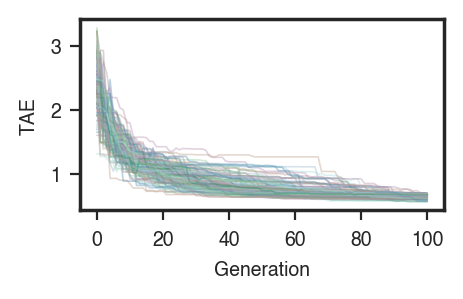

In [25]:
# plot

gen = 100

# SPECIFY DATA SET
arr_best_scores_P = onlyMAPK_best_scores_P
arr_end_scores_P = onlyMAPK_end_scores_P
arr_best_inds_P = onlyMAPK_best_inds_P
arrT_best_inds_P = onlyMAPKT_best_inds_P 


fig = plt.figure(figsize=(2.5, 1.6))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0,0])
# ax2 = fig.add_subplot(gs[1,0])
# ax3 = fig.add_subplot(gs[1,1])
# ax4 = fig.add_subplot(gs[1,2])

for i in range(len(arr_best_scores_P)):
    ax1.plot(np.linspace(0,gen,gen+1),arr_best_scores_P[i][0:gen+1],linewidth=0.6, alpha = 0.4)
ax1.set_xlabel('Generation')
ax1.set_ylabel('TAE')
            
fig.tight_layout()
            
fig.savefig('4D.png',dpi=1200,bbox_inches='tight')

## Figure 4E - Error vs. Generation visualization

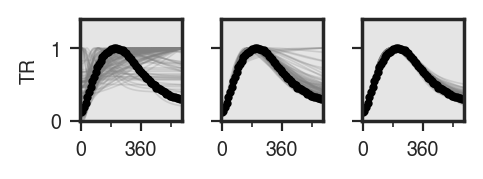

In [26]:
# Figure 4E

arr_best_scores_P = onlyMAPK_best_scores_P
arr_end_scores_P = onlyMAPK_end_scores_P
arr_best_inds_P = onlyMAPK_best_inds_P
arrT_best_inds_P = onlyMAPKT_best_inds_P 

fig = plt.figure(figsize=(2.6, 1.0))
gs = gridspec.GridSpec(1,3)
ax2 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[0,1])
ax4 = fig.add_subplot(gs[0,2])

for i in [ax3,ax4]:
    i.axes.set_yticklabels([])

hc=2
kdegGFP=10**-1
slope_off = 0
time = np.linspace(0,600,601)
gen = 50

for gen in [0,50,100]:
    SS=[]
    for j in range(len(arr_best_scores_P)):
        ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
        IC = [0,0,0,0,0,0,0]
        t  = np.linspace(0,40000,100001)
        odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
        SS.append(odes[100000,:])
    
    for j in range(len(arr_best_scores_P)):
        ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
        expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
        comp = max(expX[:,0])
        if gen == 0:
            ax2.plot(time, expX[:,0]/comp,color='gray',alpha=0.25,linewidth=0.6)
        elif gen == 50: 
            ax3.plot(time, expX[:,0]/comp,color='gray',alpha=0.25,linewidth=0.6)
        elif gen == 100: 
            if SS[j][0]/comp < 0.5:
                ax4.plot(time, expX[:,0]/comp,color='gray',alpha=0.25,linewidth=0.6)
            
# ax2.set_title('Generation 0')
# ax3.set_title('Generation 50')
# ax4.set_title('Generation 100')

for i in [ax2, ax3,ax4]:
    i.set_ylim([0,1.4])
    i.plot(times_50constant[0], data_50constant[0], 'ko', markersize=2)
    i.set_xlim([-1,601])
    i.fill_between([-1,601], 0, 1.5, facecolor='gray', alpha=0.2)
    i.xaxis.set_major_locator(plt.MultipleLocator(360))
    i.xaxis.set_minor_locator(plt.MultipleLocator(180))

ax2.set_ylabel('TR')
# ax3.set_xlabel('Time (min)')
    
            
fig.tight_layout()
            
fig.savefig('4E.png',dpi=600,bbox_inches='tight')

# Figure 5

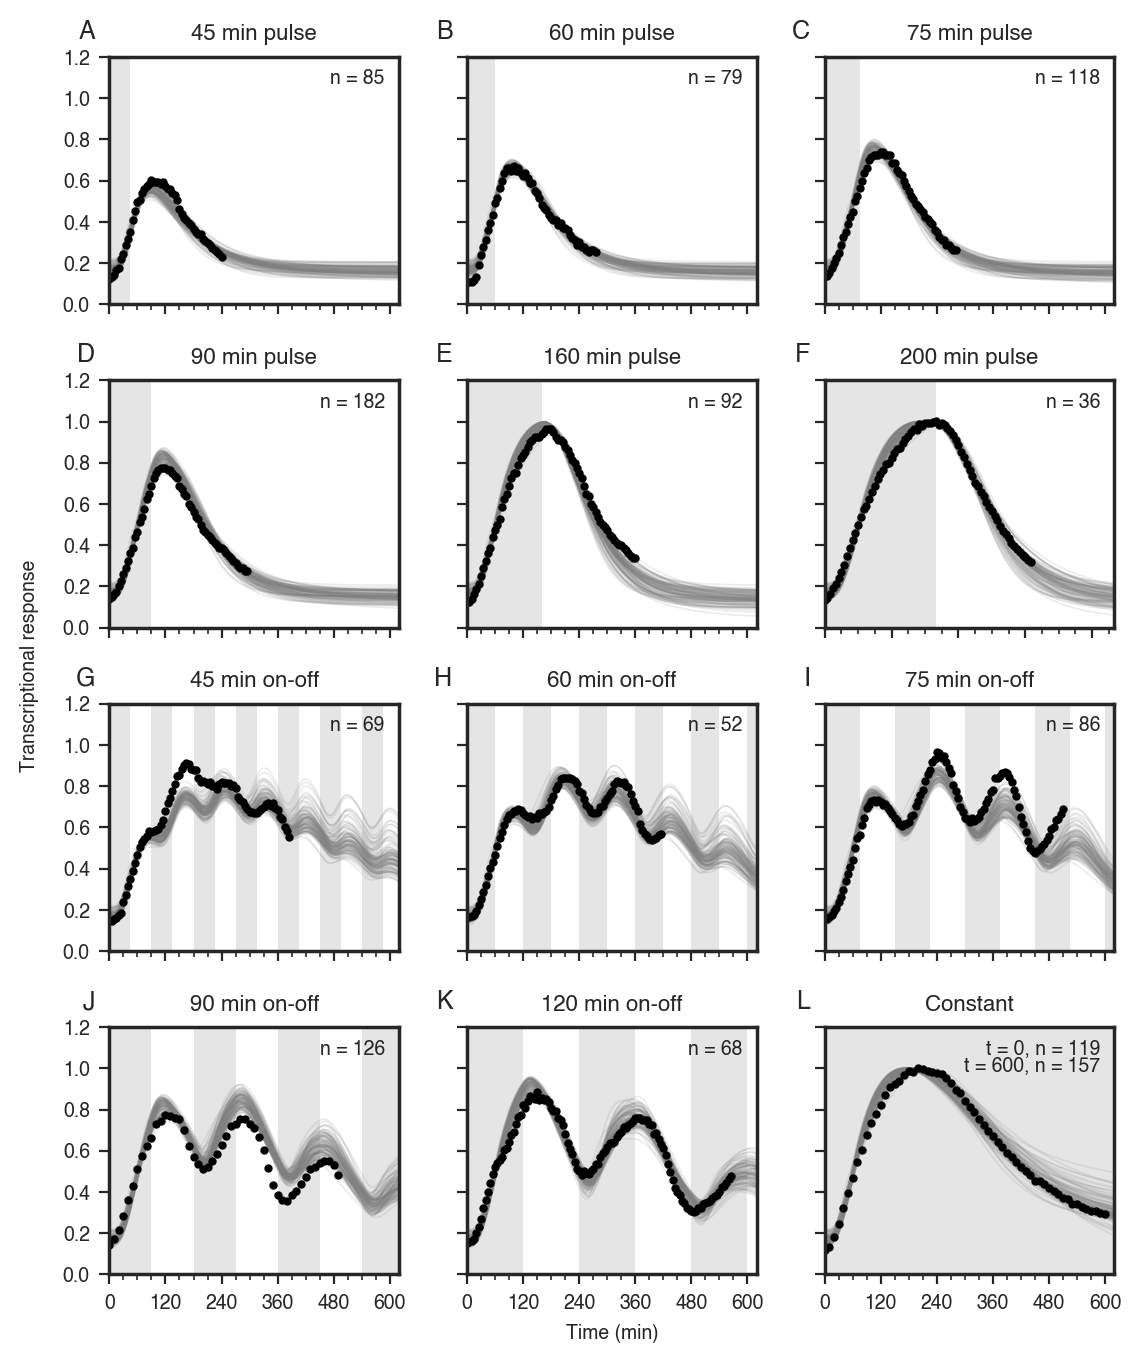

In [80]:
# Plot figure

slope_off=0

# SPECIFY DATA SET
arr_best_scores_P = onlyMAPK_best_scores_P
arr_end_scores_P = onlyMAPK_end_scores_P
arr_best_inds_P = onlyMAPK_best_inds_P
arrT_best_inds_P = onlyMAPKT_best_inds_P 

gen = 100

fig = plt.figure(figsize=(6.125, 7))
gs = gridspec.GridSpec(4,3)
A = fig.add_subplot(gs[0,0])
B = fig.add_subplot(gs[0,1])
C = fig.add_subplot(gs[0,2])
D = fig.add_subplot(gs[1,0])
E = fig.add_subplot(gs[1,1])
F = fig.add_subplot(gs[1,2])
A1 = fig.add_subplot(gs[2,0])
B1 = fig.add_subplot(gs[2,1])
C1 = fig.add_subplot(gs[2,2])
D1 = fig.add_subplot(gs[3,0])
E1 = fig.add_subplot(gs[3,1])
F1 = fig.add_subplot(gs[3,2])
ax = fig.add_subplot(gs[:,:])

for i in [ax]:
    i.spines['top'].set_color('none')
    i.spines['bottom'].set_color('none')
    i.spines['left'].set_color('none')
    i.spines['right'].set_color('none')
    i.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    i.set_facecolor('none')
    i.grid('off')
    i.axes.get_xaxis().set_visible(False)
#     i.axes.get_yaxis().set_visible(False)
    i.yaxis.set_ticks([])

for i in [A, B, C,D,E,F,A1,B1,C1]:
    i.axes.set_xticklabels([])

for i in [B, C, E, F,B1,C1,E1,F1]:
    i.axes.set_yticklabels([])
    
for i in [A,B,C,D,E,F,A1,B1,C1,D1,E1,F1]:
    i.xaxis.set_major_locator(plt.MultipleLocator(120))
    i.xaxis.set_minor_locator(plt.MultipleLocator(30))

#DEFINE STEADY STATE - WT
hc=2
kdegGFP=10**-1
time = np.linspace(0,620,621)
SS=[]
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    comp = max(expX[:,0])
    for i in [45,60,75,90,160,200]:
        expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 45:
            A.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 60: 
            B.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 75: 
            C.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 90:
            D.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 160:
            E.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 200:
            F.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)

scorefxn_time = times_50pulse
scorefxn_data = data_50pulse
A.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=2)
A.axis([0, 620, 0, 1.2])
B.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=2)
B.axis([0, 620, 0, 1.2])
C.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=2)
C.axis([0, 620, 0, 1.2])
D.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=2)
D.axis([0, 620, 0, 1.2])
E.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=2)
E.axis([0, 620, 0, 1.2])
F.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=2)
F.axis([0, 520, 0, 1.2])
# A1.plot(times_50constant[0], data_50constant[0], 'ko', markersize=2)
# A1.axis([0, 520, 0, 1.5])
# B1.plot(times_50constant[2], data_50constant[2], 'ko', markersize=2)
# B1.axis([0, 520, 0, 1.5])
# C1.plot(times_50constant[1], data_50constant[1], 'ko', markersize=2)
# C1.axis([0, 520, 0, 1.5])

for i in range(1):
    A.fill_between([i*90,i*90+45], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(1):
    B.fill_between([i*120,i*120+60], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(1):
    C.fill_between([i*150,i*150+75], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(1):
    D.fill_between([i*180,i*180+90], 0, 1.2, facecolor='gray', alpha=0.2)
for i in range(1):
    E.fill_between([i*320,i*320+160], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(1):
    F.fill_between([i*400,i*400+200], 0, 1.2, facecolor='gray', alpha=0.2)
    
ax.set_ylabel('Transcriptional response')
ax.set_xlabel('Time (min)')

A.set_title('45 min pulse',fontsize=8)
B.set_title('60 min pulse',fontsize=8)
C.set_title('75 min pulse',fontsize=8)
D.set_title('90 min pulse',fontsize=8)
E.set_title('160 min pulse',fontsize=8)
F.set_title('200 min pulse',fontsize=8)

all_axes = [A,B,C,D,E,F,A1,B1,C1,D1,E1,F1]

for i, label in enumerate(('A','B', 'C', 'D', 'E', 'F', 'G','H','I','J','K','L')):
    ax_curr = all_axes[i]
    ax_curr.text(-0.05, 1.15, label, transform=ax_curr.transAxes,
      fontsize=9, va='top', ha='right')

for i, label in enumerate((['n = 85','n = 79','n = 118','n = 182','n = 92','n = 36','n = 69','n = 52','n = 86','n = 126','n = 68','t = 0, n = 119'])):
    ax_curr = all_axes[i]
    ax_curr.text(.95,.95,label, transform=ax_curr.transAxes,
      fontsize=7, va='top', ha='right')
for i, label in enumerate((['t = 600, n = 157'])):
    ax_curr = F1
    ax_curr.text(.95,.88,label, transform=ax_curr.transAxes,
      fontsize=7, va='top', ha='right')


#DEFINE STEADY STATE - WT
hc=2
kdegGFP=10**-1
slope_off = 0
gen = 100
time = np.linspace(0,620,621)
SS=[]
for j in range(len(arr_best_scores_P)): 
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    comp = max(expX[:,0])
    for i in [90,120,150,180,240,1]:
        expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 90:
            A1.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 120: 
            B1.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 150: 
            C1.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 180:
            D1.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 240:
            E1.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 1: 
            F1.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)

scorefxn_time = times_50periodic
scorefxn_data = data_50periodic
A1.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=2)
A1.axis([0, 620, 0, 1.2])
B1.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=2)
B1.axis([0, 620, 0, 1.2])
C1.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=2)
C1.axis([0, 620, 0, 1.2])
D1.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=2)
D1.axis([0, 620, 0, 1.2])
E1.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=2)
E1.axis([0, 620, 0, 1.2])
F1.plot(times_50constant[0], data_50constant[0], 'ko', markersize=2)
F1.axis([0, 620, 0, 1.2])

for i in range(8):
    A1.fill_between([i*90,i*90+45], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(6):
    B1.fill_between([i*120,i*120+60], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(5):
    C1.fill_between([i*150,i*150+75], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(5):
    D1.fill_between([i*180,i*180+90], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(4):
    E1.fill_between([i*240,i*240+120], 0, 1.2, facecolor='gray', alpha=0.2)
    
F1.fill_between([0,620], 0, 1.2, facecolor='gray', alpha=0.2)
    
ax.set_ylabel('Transcriptional response')
E1.set_xlabel('Time (min)')
ax.yaxis.set_label_coords(-0.07,0.5)

A1.set_title('45 min on-off',fontsize=8)
B1.set_title('60 min on-off',fontsize=8)
C1.set_title('75 min on-off',fontsize=8)
D1.set_title('90 min on-off',fontsize=8)
E1.set_title('120 min on-off',fontsize=8)
F1.set_title('Constant',fontsize=8)

gs.tight_layout(fig)

plt.savefig('Figure 5.pdf',dpi=600)

# Figure S5

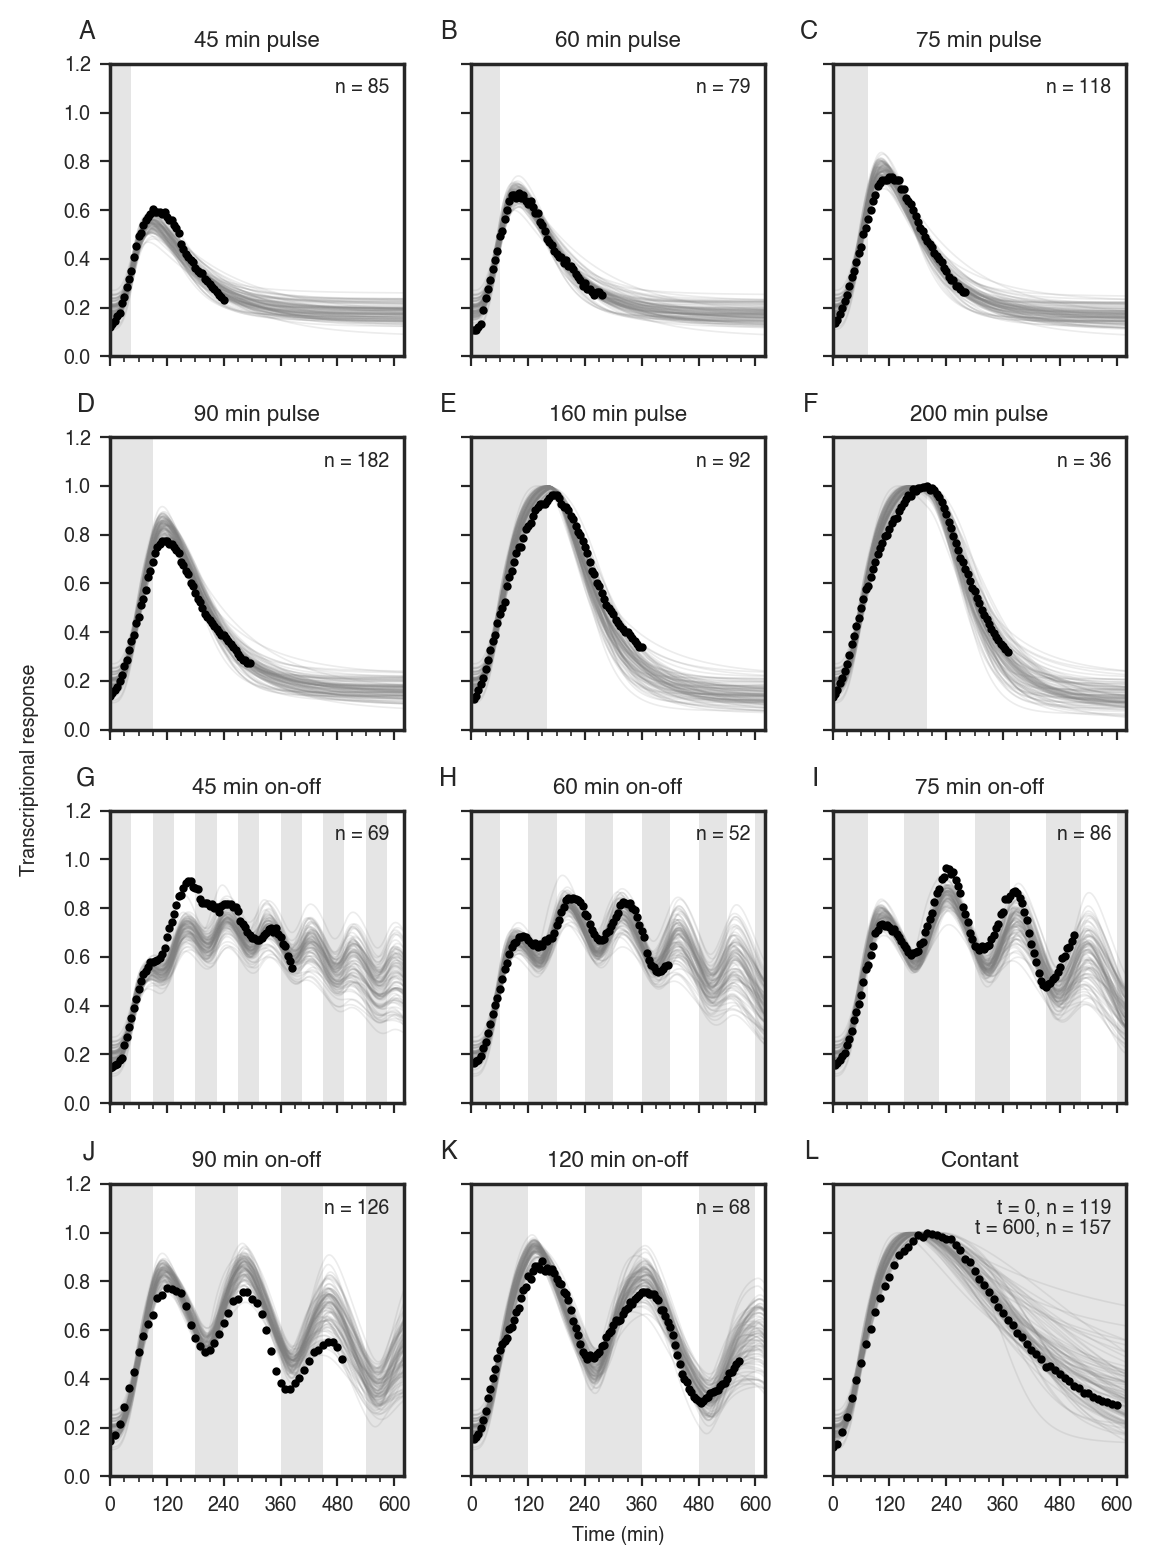

In [81]:
# Plot figure

# SPECIFY DATA SET
arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P 

gen = 100

fig = plt.figure(figsize=(6.125, 8))
gs = gridspec.GridSpec(4,3)
A = fig.add_subplot(gs[0,0])
B = fig.add_subplot(gs[0,1])
C = fig.add_subplot(gs[0,2])
D = fig.add_subplot(gs[1,0])
E = fig.add_subplot(gs[1,1])
F = fig.add_subplot(gs[1,2])
A1 = fig.add_subplot(gs[2,0])
B1 = fig.add_subplot(gs[2,1])
C1 = fig.add_subplot(gs[2,2])
D1 = fig.add_subplot(gs[3,0])
E1 = fig.add_subplot(gs[3,1])
F1 = fig.add_subplot(gs[3,2])
ax = fig.add_subplot(gs[:,:])

for i in [ax]:
    i.spines['top'].set_color('none')
    i.spines['bottom'].set_color('none')
    i.spines['left'].set_color('none')
    i.spines['right'].set_color('none')
    i.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    i.set_facecolor('none')
    i.grid('off')
    i.axes.get_xaxis().set_visible(False)
#     i.axes.get_yaxis().set_visible(False)
    i.yaxis.set_ticks([])
for i in [A, B, C,D,E,F,A1,B1,C1]:
    i.axes.set_xticklabels([])

for i in [B, C, E, F,B1,C1,E1,F1]:
    i.axes.set_yticklabels([])
    
for i in [A,B,C,D,E,F,A1,B1,C1,D1,E1,F1]:
    i.xaxis.set_major_locator(plt.MultipleLocator(120))
    i.xaxis.set_minor_locator(plt.MultipleLocator(30))

#DEFINE STEADY STATE - WT
hc=2
kdegGFP=10**-1
time = np.linspace(0,620,621)
SS=[]
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    comp = max(expX[:,0])
    for i in [45,60,75,90,160,200]:
        expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 45:
            A.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 60: 
            B.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 75: 
            C.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 90:
            D.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 160:
            E.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 200:
            F.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)

scorefxn_time = times_50pulse
scorefxn_data = data_50pulse
A.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=2)
A.axis([0, 620, 0, 1.2])
B.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=2)
B.axis([0, 620, 0, 1.2])
C.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=2)
C.axis([0, 620, 0, 1.2])
D.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=2)
D.axis([0, 620, 0, 1.2])
E.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=2)
E.axis([0, 620, 0, 1.2])
F.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=2)
F.axis([0, 620, 0, 1.2])
# A1.plot(times_50constant[0], data_50constant[0], 'ko', markersize=2)
# A1.axis([0, 520, 0, 1.5])
# B1.plot(times_50constant[2], data_50constant[2], 'ko', markersize=2)
# B1.axis([0, 520, 0, 1.5])
# C1.plot(times_50constant[1], data_50constant[1], 'ko', markersize=2)
# C1.axis([0, 520, 0, 1.5])

for i in range(1):
    A.fill_between([i*90,i*90+45], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(1):
    B.fill_between([i*120,i*120+60], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(1):
    C.fill_between([i*150,i*150+75], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(1):
    D.fill_between([i*180,i*180+90], 0, 1.2, facecolor='gray', alpha=0.2)
2 
for i in range(1):
    E.fill_between([i*320,i*320+160], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(1):
    F.fill_between([i*400,i*400+200], 0, 1.2, facecolor='gray', alpha=0.2)
    
ax.set_ylabel('Transcriptional response')
ax.set_xlabel('Time (min)')

A.set_title('45 min pulse',fontsize=8)
B.set_title('60 min pulse',fontsize=8)
C.set_title('75 min pulse',fontsize=8)
D.set_title('90 min pulse',fontsize=8)
E.set_title('160 min pulse',fontsize=8)
F.set_title('200 min pulse',fontsize=8)

all_axes = [A,B,C,D,E,F,A1,B1,C1,D1,E1,F1]

for i, label in enumerate(('A','B', 'C', 'D', 'E', 'F', 'G','H','I','J','K','L')):
    ax_curr = all_axes[i]
    ax_curr.text(-0.05, 1.15, label, transform=ax_curr.transAxes,
      fontsize=9, va='top', ha='right')
for i, label in enumerate((['n = 85','n = 79','n = 118','n = 182','n = 92','n = 36','n = 69','n = 52','n = 86','n = 126','n = 68','t = 0, n = 119'])):
    ax_curr = all_axes[i]
    ax_curr.text(.95,.95,label, transform=ax_curr.transAxes,
      fontsize=7, va='top', ha='right')
for i, label in enumerate((['t = 600, n = 157'])):
    ax_curr = F1
    ax_curr.text(.95,.88,label, transform=ax_curr.transAxes,
      fontsize=7, va='top', ha='right')


#DEFINE STEADY STATE - WT
hc=2
kdegGFP=10**-1
slope_off = 0
gen = 100
time = np.linspace(0,620,621)
SS=[]
for j in range(len(arr_best_scores_P)): 
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    comp = max(expX[:,0])
    for i in [90,120,150,180,240,1]:
        expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 90:
            A1.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 120: 
            B1.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 150: 
            C1.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 180:
            D1.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 240:
            E1.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 1:
            F1.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)

scorefxn_time = times_50periodic
scorefxn_data = data_50periodic
A1.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=2)
A1.axis([0, 620, 0, 1.2])
B1.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=2)
B1.axis([0, 620, 0, 1.2])
C1.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=2)
C1.axis([0, 620, 0, 1.2])
D1.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=2)
D1.axis([0, 620, 0, 1.2])
E1.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=2)
E1.axis([0, 620, 0, 1.2])
F1.plot(times_50constant[0], data_50constant[0], 'ko', markersize=2)
F1.axis([0, 620, 0, 1.2])

for i in range(8):
    A1.fill_between([i*90,i*90+45], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(6):
    B1.fill_between([i*120,i*120+60], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(5):
    C1.fill_between([i*150,i*150+75], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(5):
    D1.fill_between([i*180,i*180+90], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in range(4):
    E1.fill_between([i*240,i*240+120], 0, 1.2, facecolor='gray', alpha=0.2)
    
F1.fill_between([0,620], 0, 1.2, facecolor='gray', alpha=0.2)
    
ax.set_ylabel('Transcriptional response')
E1.set_xlabel('Time (min)')
ax.yaxis.set_label_coords(-0.07,0.5)

A1.set_title('45 min on-off',fontsize=8)
B1.set_title('60 min on-off',fontsize=8)
C1.set_title('75 min on-off',fontsize=8)
D1.set_title('90 min on-off',fontsize=8)
E1.set_title('120 min on-off',fontsize=8)
F1.set_title('Contant',fontsize=8)


gs.tight_layout(fig)

plt.savefig('Figure S5.pdf',dpi=600)

# Figure S8

In [29]:
# Import Cell Cycle Data
cellcycle = pd.read_csv('~/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/CellCycle.csv')
cellcycle_long = pd.wide_to_long(cellcycle, ["t="], i="id", j="timepoint")
cellcycle_long=cellcycle_long.reset_index()
cellcycle_long.head()
cellcycle_long.to_csv('yeastCellCycle.csv')

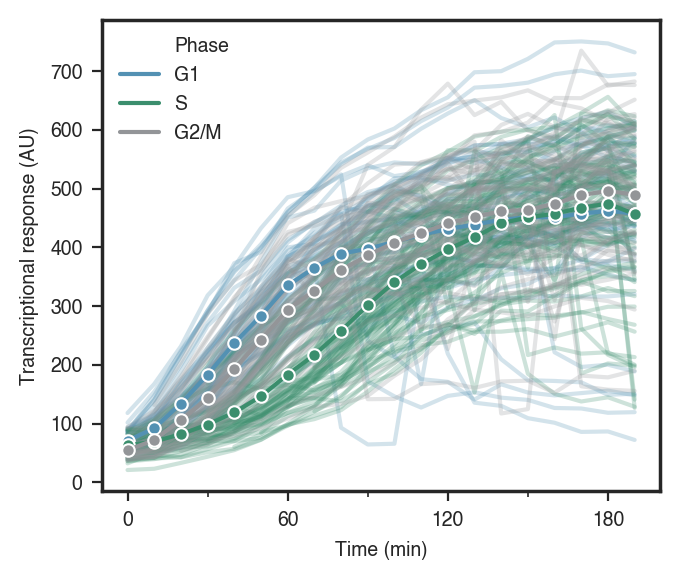

In [30]:
# plot
fig = plt.figure(figsize=(3.5, 3))
gs = gridspec.GridSpec(1,1)
A = fig.add_subplot(gs[0,0])
    
for i in [A]:
    i.xaxis.set_major_locator(plt.MultipleLocator(60))
    i.xaxis.set_minor_locator(plt.MultipleLocator(30))

sns.lineplot(data=cellcycle_long,
             x="timepoint", y='t=',hue="Phase",
             units="id", estimator=None, alpha = 0.25, ax = A)

sns.lineplot(data=cellcycle_long,markers=["o","o","o"],style="Phase",markersize = 4.5,dashes=False,
             x="timepoint", y='t=',hue="Phase", ax = A, err_style="bars", ci=0, legend = None)


A.set_xlabel('Time (min)')
A.set_ylabel('Transcriptional response (AU)')

fig.tight_layout()

plt.savefig('Figure S8.pdf',dpi=600)

# Figure S6

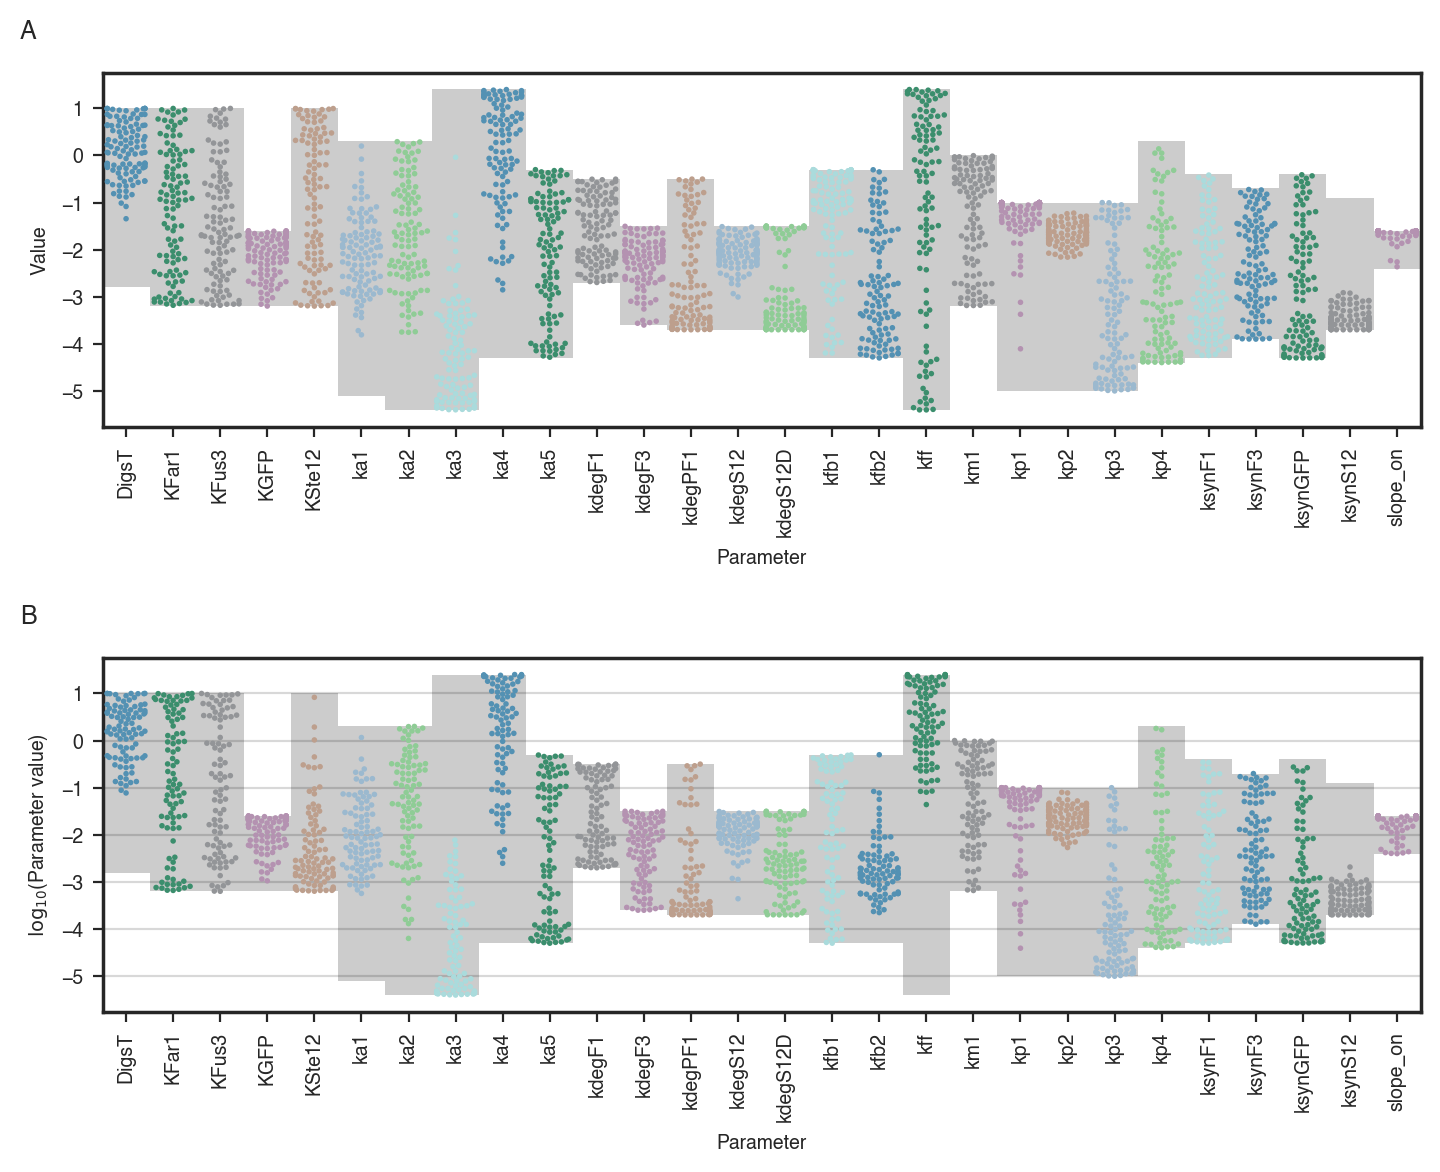

In [31]:
# Plot figure
arr_best_scores_P = onlyMAPK_best_scores_P
arr_end_scores_P = onlyMAPK_end_scores_P
arr_best_inds_P = onlyMAPK_best_inds_P
arrT_best_inds_P = onlyMAPKT_best_inds_P 

fig = plt.figure(figsize=(7.3, 6))
gs = gridspec.GridSpec(2,1)
ax3 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])

all_axes = [ax3,ax2]

for i, label in enumerate(('A','B')):
    ax_curr = all_axes[i]
    ax_curr.text(-0.05, 1.15, label, transform=ax_curr.transAxes,
      fontsize=9, va='top', ha='right')

for gen in [100]:
    
    d = []
    for i in range(len(arr_best_inds_P)):
        d.append({' ksynF3':np.log10(arr_best_inds_P[i][gen])[0],
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3],  
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7],  
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' kff1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[20],
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21], 
                   ' kdegPF1':np.log10(arr_best_inds_P[i][gen])[22], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[24],
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[25],
                   ' slope_on':np.log10(arr_best_inds_P[i][gen])[26],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[27]})

    swarm_params = pd.DataFrame(d)
    
    unstacked = swarm_params.unstack().reset_index() 
    unstacked.columns = ['Parameter', 'index', 'Value']

unstacked = unstacked.sort_values(['Parameter']).reset_index(drop=True)    

labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12','kdegS12D', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12','slope_on']
from pylab import *
g = sns.swarmplot(x="Parameter", y="Value", data=unstacked, ax=ax3, palette=fig3, size = 2)
ax3.set_xticklabels(labelnames,rotation=90)
mins = [-2.8,-3.2,-3.2,-3.2,-3.2,-5.1,-5.4,-5.4,-4.3,-4.3,-2.7,-3.6,-3.7,-3.7,-3.7,-4.3,-4.3,-5.4,-3.2,-5,-5,-5,-4.4,-4.3,-3.9,-4.3,-3.7,-2.4]
maxes = [1,1,1,-1.6,1,0.3,0.3,1.4,1.4,-0.3,-0.5,-1.5,-0.5,-1.5,-1.5,-0.3,-0.3,1.4,0,-1,-1,-1,0.3,-0.4,-0.7,-0.4,-0.9,-1.6]
for i in range(len(mins)):
    ax3.fill([i-0.5,i+0.5,i+0.5,i-0.5], [mins[i],mins[i],maxes[i],maxes[i]], 'k', alpha=0.2)

plt.ylabel('$\log_{10}$(Parameter value)')

gs.tight_layout(fig)

plt.grid(which='major',axis='y',color='gray',alpha = 0.3)

arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P 

for gen in [100]:
    
    d = []
    for i in range(len(arr_best_inds_P)):
        d.append({' ksynF3':np.log10(arr_best_inds_P[i][gen])[0],
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3],  
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7],  
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' kff1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[20],
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21], 
                   ' kdegPF1':np.log10(arr_best_inds_P[i][gen])[22], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[24],
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[25],
                   ' slope_on':np.log10(arr_best_inds_P[i][gen])[26],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[27]})

    swarm_params = pd.DataFrame(d)
    
    unstacked = swarm_params.unstack().reset_index() 
    unstacked.columns = ['Parameter', 'index', 'Value']
    
unstacked = unstacked.sort_values(['Parameter']).reset_index(drop=True)
    
labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12','kdegS12D', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12','slope_on']
from pylab import *
g = sns.swarmplot(x="Parameter", y="Value", data=unstacked, ax=ax2, palette=fig3, size = 2)
ax2.set_xticklabels(labelnames,rotation=90)
mins = [-2.8,-3.2,-3.2,-3.2,-3.2,-5.1,-5.4,-5.4,-4.3,-4.3,-2.7,-3.6,-3.7,-3.7,-3.7,-4.3,-4.3,-5.4,-3.2,-5,-5,-5,-4.4,-4.3,-3.9,-4.3,-3.7,-2.4]
maxes = [1,1,1,-1.6,1,0.3,0.3,1.4,1.4,-0.3,-0.5,-1.5,-0.5,-1.5,-1.5,-0.3,-0.3,1.4,0,-1,-1,-1,0.3,-0.4,-0.7,-0.4,-0.9,-1.6]
for i in range(len(mins)):
    ax2.fill([i-0.5,i+0.5,i+0.5,i-0.5], [mins[i],mins[i],maxes[i],maxes[i]], 'k', alpha=0.2)

plt.ylabel('$\log_{10}$(Parameter value)')

gs.tight_layout(fig)

plt.grid(which='major',axis='y',color='gray',alpha = 0.3)

plt.savefig('Figure S6.pdf',dpi=600)

# Figure 2 D and E

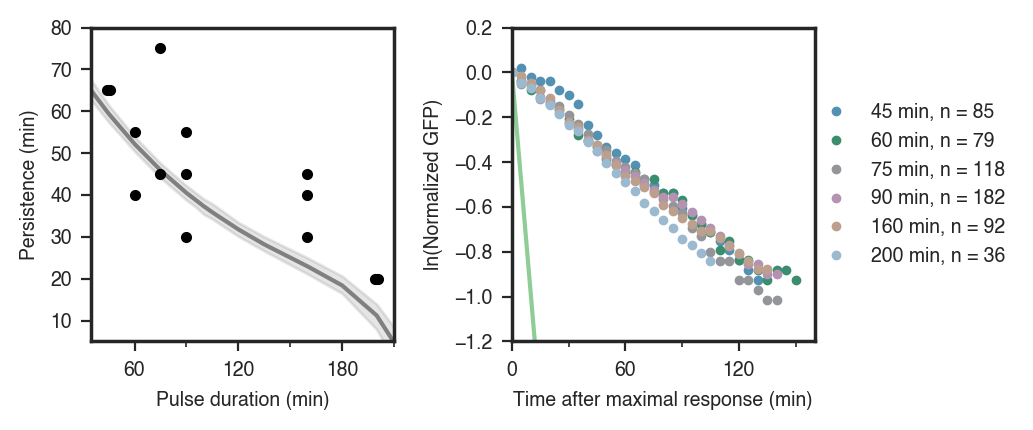

In [55]:
# Persistance
gen=100
slope_off=0
arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P 

dur = []
per = []

# Plot
fig = plt.figure(figsize=(5.25, 2.25))
gs = gridspec.GridSpec(1,2)
A = fig.add_subplot(gs[0,0])
B = fig.add_subplot(gs[0,1])

#50nM
hc=2
kdegGFP=10**-1
time = np.linspace(0,570,571)
SS=[]
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

comp = []
indexes = []
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    comp.append(max(expX[:,0]))
    A.plot(time, expX[:,0]/comp[j],color='gray',alpha=0.15,linewidth=0.6)
    for i in [35,45, 60, 75, 90, 95, 100, 105, 120, 135, 160,180,200,220]:
        dur.append(i)
        expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        cut = max(expX[:,0])*0.975
        a = []
        for l in expX[:,0]:
            if l < cut:
                a.append(1)
            else:
                a.append(0)
        b = [0,1]
        for k in range(len(a)):
            if a[k:k+len(b)] == b:
                indexes.append(int(k+1))
                break

d = {'Duration':dur,'Max':indexes, 'Persistance':[x1 - x2 for (x1, x2) in zip(indexes, dur)]}

df_per = pd.DataFrame(d)

sns.lineplot(x="Duration", y="Persistance", data=df_per, ci = 99.9, color = 'gray', ax = A)

# Import memory
pulse = [90,90,90,75,75,60,60,44,46,160,160,160,199,201]
memory =[55,45,30,45,75,40,55,65,65,40.,45.,30.,20.,20.]


A.plot(pulse,memory,'ko',markersize=3)
A.set_xlabel('Pulse duration (min)')
B.set_xlabel('Time after maximal response (min)')
A.set_ylabel('Persistence (min)')
B.set_ylabel('ln(Normalized GFP)')
A.xaxis.set_major_locator(plt.MultipleLocator(60))
A.xaxis.set_minor_locator(plt.MultipleLocator(30))
B.xaxis.set_major_locator(plt.MultipleLocator(60))
B.xaxis.set_minor_locator(plt.MultipleLocator(30))

dur = [45,60,75,90,160,200]
lambdas = []
for i in [0,1,2,3,4,5]:
    t = (times_50pulse[i]-dur[i]-65)[int((dur[i]+65)/5):]
    y = np.log(np.array(data_50pulse[i])/data_50pulse[i][int((dur[i]+65)/5)])[int((dur[i]+65)/5):]
    y = y[~np.isnan(t)]
    t = t[~np.isnan(t)]
    B.plot(t,y,marker='o',markersize=2.5,linestyle='None')
    K, A_log = np.polyfit(t.reshape(len(t)), y.reshape(len(t)), 1)
    lambdas.append(np.log(2)/-K)
# plt.xlabel('Time after stimulus removal (min)')
# plt.fill_between([-210,0], -5, 1.2, facecolor='gray', alpha=0.2)
B.plot(t,(t * (-np.log(2)/7)))
A.set_xlim([35,210])
A.set_ylim([5,80])
B.set_xlim([0,160])
B.set_ylim([-1.2,0.2])
lgd = plt.legend(['45 min, n = 85','60 min, n = 79','75 min, n = 118', '90 min, n = 182', '160 min, n = 92', '200 min, n = 36'],loc='center left', bbox_to_anchor=(0.95, 0.5),ncol=1,fontsize=7)

gs.tight_layout(fig)

fig.savefig('2DE.pdf',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

# Mutant predictions

In [33]:
# Define Far1 score function
arr_best_scores_P = onlyMAPK_best_scores_P
arr_end_scores_P = onlyMAPK_end_scores_P
arr_best_inds_P = onlyMAPK_best_inds_P
arrT_best_inds_P = onlyMAPKT_best_inds_P 

def scorefxn1(scorefxn_time, scorefxn_data, arr_parameters, time, plot_bool, norm):
    mse_total = 0
    norm=norm
    # parameters to be learned
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    
    # Solve steady state
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
    #print TE
    SS = odes[100000,:]
    # loop through different periods 
    expX = simulate_singlepulse_experiment(arr_parameters, t1, 1,SS)

    # get index of time points closest 
    idx_closest_time_points = []
    for each_time in times_50constant[0][~np.isnan(times_50constant[0])]:
        closest_idx = np.abs(t1 - each_time).argmin()
        idx_closest_time_points.append(closest_idx)
    
    # use indexes of time points to get data points to score against
    expX_scorefxn_data = expX[[idx_closest_time_points]]

    #SCORE IT! using MSE
    expX_mse = (abs(data_50constant[0][~np.isnan(data_50constant[0])] - expX_scorefxn_data[:,0]/norm)).mean() 
    #print('MSE Exp' + str(idx+1) + ': ', expX_mse)
    mse_total += expX_mse
    
#     if expX_mse > 0.25:
#         plt.plot(t1,expX[:,0]/norm,'r')
#     else:
#         plt.plot(t1,expX[:,0]/norm,'k')
        
    return mse_total

#Calculate Digs error and set threshold (33%)
hc =2
IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)
gen = 100
kdegGFP = 10**-1
t1 = np.linspace(0,600,6000)

scores = []

for j in range(len(arr_best_inds_P[:,gen])):
    expX = 0
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    odes = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], t, 0, IC)
    SS=odes[100000,:]
    expX1 = simulate_periodic_experiment(arr_best_inds_P[j][gen], t1, 1, SS)
    norm = max(expX1[:,0])
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    kp4,ksynF1,ka5,kp3 = [0,0,0,0]
    curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
    scores.append(scorefxn1(time, data_50constant[2], curr_params, time, False, norm))
    
# Determine threshold for good scores
scores_bool = []
for i in scores:
    if i > 0.25:
        scores_bool.append(1)
    else:
        scores_bool.append(0)
print(sum(scores_bool)/len(scores_bool))
far1_scores = scores_bool

# plt.plot(times_50constant[0],data_50constant[0],'bo')
# plt.ylim([0,2])

/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


0.3425925925925926


In [34]:
# Define BFB score function
arr_best_scores_P = onlyMAPK_best_scores_P
arr_end_scores_P = onlyMAPK_end_scores_P
arr_best_inds_P = onlyMAPK_best_inds_P
arrT_best_inds_P = onlyMAPKT_best_inds_P 

def scorefxn1(scorefxn_time, scorefxn_data, arr_parameters, time, plot_bool, norm):
    mse_total = 0
    norm=norm
    # parameters to be learned
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    
    # Solve steady state
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
    #print TE
    SS = odes[100000,:]
    # loop through different periods 
    expX = simulate_singlepulse_experiment(arr_parameters, t1, 1,SS)

    # get index of time points closest 
    idx_closest_time_points = []
    for each_time in times_50constant[1][~np.isnan(times_50constant[1])]:
        closest_idx = np.abs(t1 - each_time).argmin()
        idx_closest_time_points.append(closest_idx)
    
    # use indexes of time points to get data points to score against
    expX_scorefxn_data = expX[[idx_closest_time_points]]

    #SCORE IT! using MSE
    expX_mse = (abs(data_50constant[1][~np.isnan(data_50constant[1])] - expX_scorefxn_data[:,0]/norm)).mean()
    #print('MSE Exp' + str(idx+1) + ': ', expX_mse)
    mse_total += expX_mse
    
#     if expX_mse < 0.28:
#         plt.plot(t1,expX[:,0]/norm,'r')
#     else:
#         plt.plot(t1,expX[:,0]/norm,'k')
        
    return mse_total

# Calculate Digs error and set threshold (33%)
hc =2
IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)
gen = 100
kdegGFP = 10**-1
t1 = np.linspace(0,600,6000)

scores = []

for j in range(len(arr_best_inds_P[:,gen])):
    expX = 0
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    odes = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], t, 0, IC)
    SS=odes[100000,:]
    expX1 = simulate_periodic_experiment(arr_best_inds_P[j][gen], t1, 1, SS)
    norm = max(expX1[:,0])
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    kfb2 = 0
    curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
    scores.append(scorefxn1(time, data_50constant[1], curr_params, time, False, norm))
    
# Determine threshold for good scores
scores_bool = []
for i in scores:
    if i < 0.28:
        scores_bool.append(1)
    else:
        scores_bool.append(0)
print(sum(scores_bool)/len(scores_bool))
bfb_scores = scores_bool

# plt.plot(times_50constant[1],data_50constant[1],'bo')
# plt.ylim([0,2])

/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


0.21296296296296297


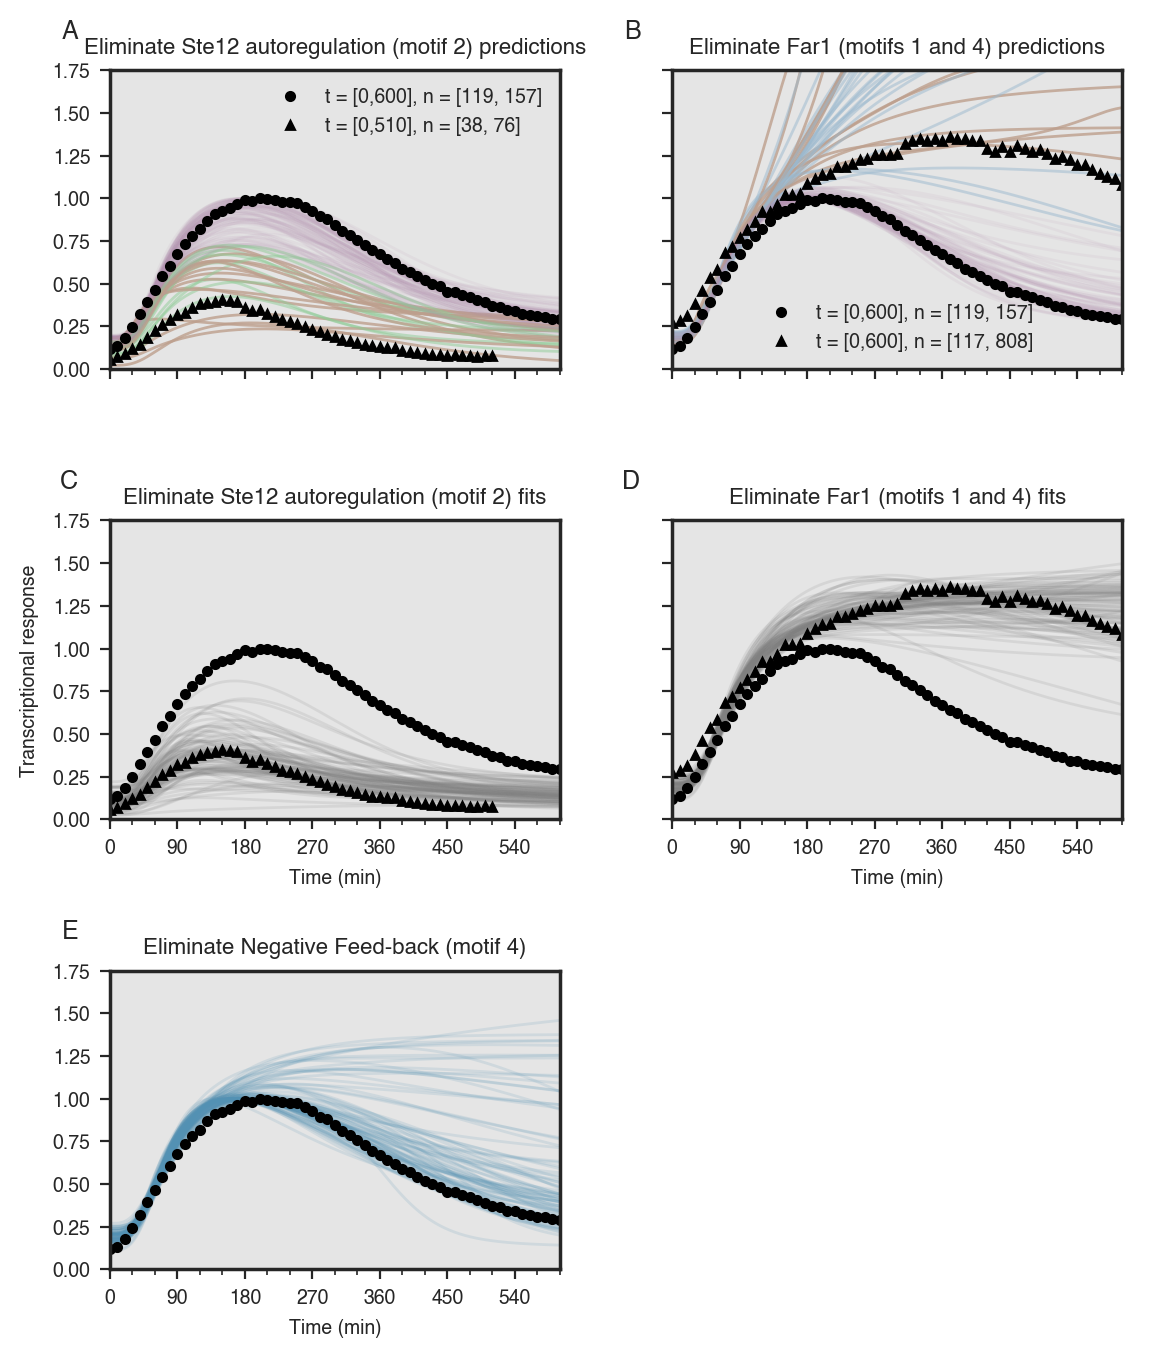

In [86]:
#Specify Figure
arr_best_scores_P = onlyMAPK_best_scores_P
arr_end_scores_P = onlyMAPK_end_scores_P
arr_best_inds_P = onlyMAPK_best_inds_P
arrT_best_inds_P = onlyMAPKT_best_inds_P 

hc =2
fig = plt.figure(figsize=(6.125,7))
gs = gridspec.GridSpec(3, 2)
A1 = fig.add_subplot(gs[0,1])
B1 = fig.add_subplot(gs[0,0])
C1 = fig.add_subplot(gs[1,0])
D1 = fig.add_subplot(gs[1,1])
# E1 = fig.add_subplot(gs[2,0])
F1 = fig.add_subplot(gs[2,0])
ax = fig.add_subplot(gs[:,:])

all_axes = [A1,B1,C1,D1,F1]

for i, label in enumerate(('B','A', 'C', 'D', 'E')):
    ax_curr = all_axes[i]
    ax_curr.text(-0.07, 1.17, label, transform=ax_curr.transAxes,
      fontsize=9, va='top', ha='right')

for i in [ax]:
    i.spines['top'].set_color('none')
    i.spines['bottom'].set_color('none')
    i.spines['left'].set_color('none')
    i.spines['right'].set_color('none')
    i.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    i.set_facecolor('none')
    i.grid('off')
    i.axes.get_xaxis().set_visible(False)
#     i.axes.get_yaxis().set_visible(False)
    i.yaxis.set_ticks([])

for i in [A1,B1]:
    i.axes.set_xticklabels([])

for i in [A1,D1]:
    i.axes.set_yticklabels([])
    
for i in [A1,B1,C1,D1,F1]:
    i.xaxis.set_major_locator(plt.MultipleLocator(90))
    i.xaxis.set_minor_locator(plt.MultipleLocator(30))
    
F1.set_xlabel('Time (min)')
C1.set_xlabel('Time (min)')
D1.set_xlabel('Time (min)')
ax.set_ylabel('Transcriptional response')

IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)
gen = 100
kdegGFP = 10**-1
t1 = np.linspace(0,600,6000)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(9)

for j in range(len(arr_best_inds_P[:,gen])):
    for i in range(4):
        expX = 0
        ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
        curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
        ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
        odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
        SS=odes[100000,:]
        expX = simulate_singlepulse_experiment(curr_params, t1, 1,SS)
        norm = max(expX[:,0])
        col = "#B492B1"
        a = 0.1
        lw = 1
#         if (far1_scores)[j] == 1:
#             col = "#9BB9CF"
#         if (bfb_scores)[j] == 1:
#             col = "#8FCC96"
#         if np.add(far1_scores,bfb_scores)[j] == 2:
#             col = "#3B8E6D"
        # FAR1 DELETE
        if i == 1:
            if (far1_scores)[j] == 1:
                col = "#9BB9CF"
                a = 0.5
            if np.add(far1_scores,bfb_scores)[j] == 2:
                col = '#BD9F8D'
                a = 0.8
            kp4,ksynF1,ka5,kp3 = [0,0,0,0]
            curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
            ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
            odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_singlepulse_experiment(curr_params, t1, 1,SS)
            A1.plot(t1,expX[:,0]/norm,color=col,alpha=a,linewidth=lw)
        # pSTE5-STE12
        elif i == 3:
            if (bfb_scores)[j] == 1:
                col = "#8FCC96"
                a = 0.5
            if np.add(far1_scores,bfb_scores)[j] == 2:
                col = '#BD9F8D'
                a = 0.8
            kfb2 = 0
            curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
            ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
            odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_singlepulse_experiment(curr_params, t1,1,SS)
            B1.plot(t1,expX[:,0]/norm,color=col,alpha=a,linewidth=lw)
            
arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P 
            
for j in range(len(arr_best_inds_P[:,gen])):
    for i in range(4):
        expX = 0
        ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
        curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
        ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
        odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
        SS=odes[100000,:]
        expX = simulate_singlepulse_experiment(curr_params, t1, 1,SS)
        norm = max(expX[:,0])
        col = 'gray'
        a = 0.15
        lw = 1
        # FAR1 DELETE
        if i == 1:
            kp4,ksynF1,ka5,kp3 = [0,0,0,0]
            curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
            ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
            odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_singlepulse_experiment(curr_params, t1, 1,SS)
            D1.plot(t1,expX[:,0]/norm,color=col,alpha=a,linewidth=lw)
        # pSTE5-STE12
        elif i == 3:
            kfb2 = 0
            curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
            ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
            odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_singlepulse_experiment(curr_params, t1,1,SS)
            C1.plot(t1,expX[:,0]/norm,color=col,alpha=a,linewidth=lw)
        # Broken IFF
#         if i == 0:
#             col = '#5391B3'
#             kff = 0
#             curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
#             ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
#             odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
#             SS=odes[100000,:]
#             expX = simulate_singlepulse_experiment(curr_params, t1, 1,SS)
#             E1.plot(t1,expX[:,0]/norm,color=col,alpha=a,linewidth=lw)
        # Broken NFB
        if i == 2:
            col = '#5391B3'
            ka5 = 0
            curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
            ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
            odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_singlepulse_experiment(curr_params, t1, 1,SS)
            F1.plot(t1,expX[:,0]/norm,color=col,alpha=a,linewidth=lw)

for i in [A1,B1,C1,D1,F1]:
    i.set_ylim([0,1.75])
    i.set_xlim([0,600])
    
# for i in [A2,B2,C2,D2,E2]:
#     i.fill_between([0,45], 0, 1.75, facecolor='gray', alpha=0.2)
#     i.set_xlim([0,180])

for i in [A1,B1,C1,D1,F1]: 
    i.fill_between([0,600], 0, 1.75, facecolor='gray', alpha=0.2)
    
A1.plot(times_50constant[2],data_50constant[2],'k^',markersize=3)
B1.plot(times_50constant[1],data_50constant[1],'k^',markersize=3)
D1.plot(times_50constant[2],data_50constant[2],'k^',markersize=3)
C1.plot(times_50constant[1],data_50constant[1],'k^',markersize=3)

A1.plot(times_50constant[0],data_50constant[0],'ko',markersize=3)
B1.plot(times_50constant[0],data_50constant[0],'ko',markersize=3)
C1.plot(times_50constant[0],data_50constant[0],'ko',markersize=3)
D1.plot(times_50constant[0],data_50constant[0],'ko',markersize=3)
# E1.plot(times_50constant[0],data_50constant[0],'ko',markersize=2)
F1.plot(times_50constant[0],data_50constant[0],'ko',markersize=3)

B1.set_title('Eliminate Ste12 autoregulation (motif 2) predictions',fontsize = 8)
A1.set_title('Eliminate Far1 (motifs 1 and 4) predictions',fontsize = 8)
C1.set_title('Eliminate Ste12 autoregulation (motif 2) fits',fontsize = 8)
D1.set_title('Eliminate Far1 (motifs 1 and 4) fits',fontsize = 8)
# E1.set_title('Eliminate Incoherent Feed-forward (motif 1)',fontsize = 8)
F1.set_title('Eliminate Negative Feed-back (motif 4)',fontsize = 8)
# C.set_title('Motif 2: Positive feedback to MAPK',fontsize = 9)
# D.set_title('Motif 3: Slow rebinding of transcriptional repressors',fontsize = 9)
# E.set_title('Motif 4: Negative feedback',fontsize = 9)

legend_elements = [Line2D([0], [0], marker='o', color='none', label='Scatter', markerfacecolor='k', markersize=3),
                   Line2D([0], [0], marker='^', color='none', label='Scatter', markerfacecolor='k', markersize=3)]

A1.legend(legend_elements,['t = [0,600], n = [119, 157]','t = [0,600], n = [117, 808]'],loc='lower center', fontsize=7)
B1.legend(legend_elements,['t = [0,600], n = [119, 157]','t = [0,510], n = [38, 76]'],loc='best', fontsize=7)

ax.yaxis.set_label_coords(-0.07,0.5)

fig.tight_layout()

fig.savefig('Figure 6.pdf',dpi=600)

# Figure 8

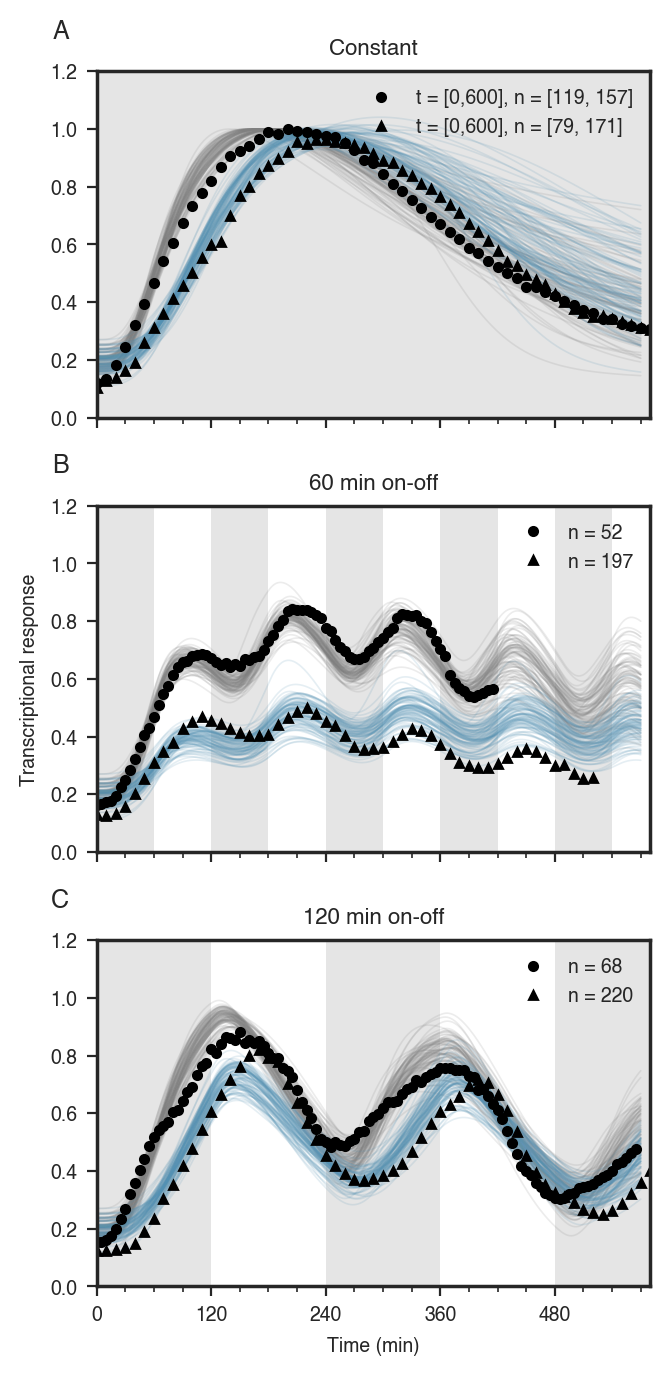

In [91]:
# plot
# SPECIFY DATA SET
arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P 

fig = plt.figure(figsize=(3.5, 7))
gs = gridspec.GridSpec(3,1)
A = fig.add_subplot(gs[0,:])
B = fig.add_subplot(gs[1,:])
C = fig.add_subplot(gs[2,:])
ax = fig.add_subplot(gs[:,:])

all_axes = [A,B,C]

for i, label in enumerate(('A','B', 'C')):
    ax_curr = all_axes[i]
    ax_curr.text(-0.05, 1.15, label, transform=ax_curr.transAxes,
      fontsize=9, va='top', ha='right')

# remove figure markings
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('none')
ax.grid('off')

for i in [A, B]:
    i.axes.set_xticklabels([])

for i in [A,B,C]:
    i.xaxis.set_major_locator(plt.MultipleLocator(120))
    i.xaxis.set_minor_locator(plt.MultipleLocator(30))


#50nM
hc=2
kdegGFP=10**-1
time = np.linspace(0,570,571)
SS=[]
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

comp = []
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    comp.append(max(expX[:,0]))
    A.plot(time, expX[:,0]/comp[j],color='gray',alpha=0.15,linewidth=0.6)
    for i in [120,240]:
        expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 120:
            B.plot(time, expX[:,0]/comp[j],color='gray',alpha=0.15,linewidth=0.6)
        elif i == 240: 
            C.plot(time, expX[:,0]/comp[j],color='gray',alpha=0.15,linewidth=0.6)

scores10 = []
#10nM
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    slope_on = slope_on*0.25
    params = [ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D]
    for i in [120,240]:
        expX = simulate_periodic_experiment(params, time, i,SS[j])
        if i == 120:
            B.plot(time, expX[:,0]/comp[j],color='#5391B3',alpha=0.15,linewidth=0.6)
            scores10.append(1)
        elif i == 240: 
            C.plot(time, expX[:,0]/comp[j],color='#5391B3',alpha=0.15,linewidth=0.6)
    expX = simulate_periodic_experiment(params, time, 1,SS[j])
    A.plot(time, expX[:,0]/comp[j],color='#5391B3',alpha=0.15,linewidth=0.6)

xmax = 580

scorefxn_time = times_10periodic
scorefxn_data = data_10periodic
B.plot(scorefxn_time[2], scorefxn_data[2], 'k^', markersize=3)
B.axis([0, xmax, 0, 1.2])
C.plot(scorefxn_time[5], scorefxn_data[5], 'k^', markersize=3)
C.axis([0, xmax, 0, 1.2])
A.plot(scorefxn_time[0], scorefxn_data[0], 'k^', markersize=3)
A.axis([0, xmax, 0, 1.2])

scorefxn_time = times_50periodic
scorefxn_data = data_50periodic
B.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=3)
B.axis([0, xmax, 0, 1.2])
C.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=3)
C.axis([0, xmax, 0, 1.2])

A.plot(times_50constant[0], data_50constant[0], 'ko', markersize=3)
A.axis([0, xmax, 0, 1.2])

B.set_ylabel('Transcriptional response')
C.set_xlabel('Time (min)')

A.set_title('Constant',fontsize=8)
B.set_title('60 min on-off',fontsize=8)
C.set_title('120 min on-off',fontsize=8)

legend_elements = [Line2D([0], [0], marker='o', color='none', label='Scatter', markerfacecolor='k', markersize=3),
                   Line2D([0], [0], marker='^', color='none', label='Scatter', markerfacecolor='k', markersize=3)]

A.legend(legend_elements,['t = [0,600], n = [119, 157]','t = [0,600], n = [79, 171]'],loc='upper right', fontsize=7)
B.legend(legend_elements,['n = 52','n = 197'],loc='best', fontsize=7)
C.legend(legend_elements,['n = 68','n = 220'],loc='best', fontsize=7)

for i in range(10):
    B.fill_between([i*120,i*120+60], 0, 1.2, facecolor='gray', alpha=0.2)
    C.fill_between([i*240,i*240+120], 0, 1.2, facecolor='gray', alpha=0.2)

A.fill_between([0,620], 0, 1.5, facecolor='gray', alpha=0.2)

fig.tight_layout()

plt.savefig('Figure 8.pdf',dpi=600)

# Figure 7

In [37]:
# Define BFB score function
arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P  

def scorefxn1(scorefxn_time, scorefxn_data, arr_parameters, time, plot_bool, norm):
    mse_total = 0
    norm=norm
    # parameters to be learned
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_parameters
    # parameters to be kept constant
    DigsT = 0
    
    # Solve steady state
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
    #print TE
    SS = odes[100000,:]
    # loop through different periods 
    expX = simulate_singlepulse_experiment(arr_parameters, t1, 90,SS)

    # get index of time points closest 
    idx_closest_time_points = []
    for each_time in times_mutpulse[2][~np.isnan(times_mutpulse[2])]:
        closest_idx = np.abs(t1 - each_time).argmin()
        idx_closest_time_points.append(closest_idx)
    
    # use indexes of time points to get data points to score against
    expX_scorefxn_data = expX[[idx_closest_time_points]]

    #SCORE IT! using MSE
    expX_mse = (abs(data_mutpulse[2][~np.isnan(data_mutpulse[2])] - expX_scorefxn_data[:,0]/norm)).mean()
    #print('MSE Exp' + str(idx+1) + ': ', expX_mse)
    mse_total += expX_mse
    
#     if expX_mse < 0.28:
#         plt.plot(t1,expX[:,0]/norm,'r')
#     else:
#         plt.plot(t1,expX[:,0]/norm,'k')
        
    return mse_total

# Calculate Digs error and set threshold (33%)
hc =2
IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)
gen = 100
kdegGFP = 10**-1
t1 = np.linspace(0,600,6000)

scores = []

for j in range(len(arr_best_inds_P[:,gen])):
    expX = 0
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    odes = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], t, 0, IC)
    SS=odes[100000,:]
    expX1 = simulate_periodic_experiment(arr_best_inds_P[j][gen], t1, 1, SS)
    norm = max(expX1[:,0])
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    DigsT=0
    curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
    scores.append(scorefxn1(time, data_50constant[1], curr_params, time, False, norm))
    
# Determine threshold for good scores
scores_bool = []
for i in scores:
    if i < 0.28:
        scores_bool.append(1)
    else:
        scores_bool.append(0)
print(sum(scores_bool)/len(scores_bool))
dig_scores = scores_bool

# plt.plot(times_mutpulse[2],data_mutpulse[2],'bo')
# plt.ylim([0,2])
# plt.xlim([0,400])

/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


0.29347826086956524


/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


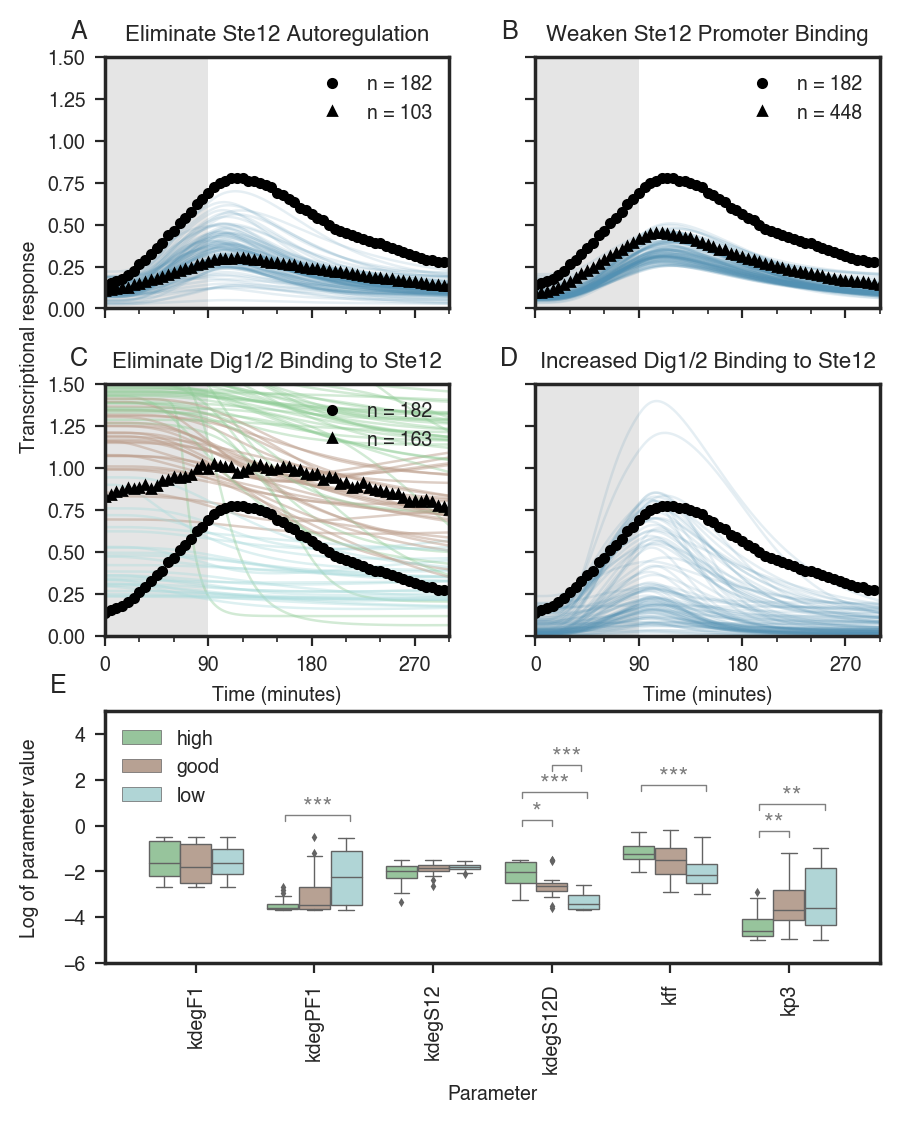

In [90]:
#Specify Figure
arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P 

hc =2
fig = plt.figure(figsize=(5.0,6.0))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.25, hspace=0.3) # set the spacing between axes.
D1 = fig.add_subplot(gs[0,0])
A1 = fig.add_subplot(gs[0,1])
B1 = fig.add_subplot(gs[1,0])
C1 = fig.add_subplot(gs[1,1])
# D1 = fig.add_subplot(gs[1,1])
ax_box = fig.add_subplot(gs[2,0:2])
ax = fig.add_subplot(gs[0:2,:])

all_axes = [D1,A1,B1,C1,ax_box]

for i, label in enumerate(('A','B', 'C','D','E')):
    ax_curr = all_axes[i]
    ax_curr.text(-0.05, 1.15, label, transform=ax_curr.transAxes,
      fontsize=9, va='top', ha='right')

for i in [ax]:
    i.spines['top'].set_color('none')
    i.spines['bottom'].set_color('none')
    i.spines['left'].set_color('none')
    i.spines['right'].set_color('none')
    i.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    i.set_facecolor('none')
    i.grid('off')
    i.axes.get_xaxis().set_visible(False)
#     i.axes.get_yaxis().set_visible(False)
    i.yaxis.set_ticks([])
    
ax.yaxis.set_label_coords(-0.085,0.5)
ax_box.yaxis.set_label_coords(-0.085,0.5)

for i in [A1,D1]:
    i.axes.set_xticklabels([])

for i in [A1,C1]:
    i.axes.set_yticklabels([])
    
for i in [A1,B1,C1,D1]:
    i.xaxis.set_major_locator(plt.MultipleLocator(90))
    i.xaxis.set_minor_locator(plt.MultipleLocator(30))
    
B1.set_xlabel('Time (minutes)')
C1.set_xlabel('Time (minutes)')
ax.set_ylabel('Transcriptional response')

IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)
gen = 100
kdegGFP = 10**-1
t1 = np.linspace(0,600,6000)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(9)
    
dig_max = []
digslow_max = []
bfb_max = []
wt_max = []
pre_max = []
neg_amp = []
wt_amp = []
high_low = []
for j in range(len(arr_best_inds_P[:,gen])):
    for i in range(6):
        expX = 0
        ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
        curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
        ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
        odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
        SS=odes[100000,:]
        expX = simulate_singlepulse_experiment(curr_params, t1, 1,SS)
        norm = max(expX[:,0])
        col = '#5391B3'
        a = 0.15
        lw = 0.9
        # DIG DOUBLE DELETE
        if i == 0:
            DigsT = 0
            curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
            ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
            odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_singlepulse_experiment(curr_params, t1, 90,SS)
            if expX[0,0]/norm < 1:
                col = '#AADBDC'
                a = 0.4
                high_low.append('low')
            else:
                col = '#8FCC96'
                a = 0.4
                high_low.append('high')
            if dig_scores[j] == 1:
                col = '#BD9F8D'
                a = 0.5
            B1.plot(t1,expX[:,0]/norm,color=col,alpha=a,linewidth=lw)
        # PRE MUTANT
        elif i == 1:
            KGFP = KGFP*3.33
            curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
            ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
            odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_singlepulse_experiment(curr_params, t1,90,SS)
            pre_max.append(np.where(expX[:,0] == max(expX[:,0])))
            A1.plot(t1,expX[:,0]/norm,color=col,alpha=a,linewidth=lw)
        # FASTER REBINDING 
        elif i == 2:
            ka1 = ka1*5
            curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
            ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
            odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_singlepulse_experiment(curr_params, t1,90,SS)
            dig_max.append(np.where(expX[:,0] == max(expX[:,0])))
            C1.plot(t1,expX[:,0]/norm,color=col,alpha=a,linewidth=lw)
        # BROKEN POSITIVE FEEDBACK
        elif i == 3:
            kfb2 = 0
            curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
            ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
            odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_singlepulse_experiment(curr_params, t1,90,SS)
            bfb_max.append(np.where(expX[:,0] == max(expX[:,0])))
            D1.plot(t1,expX[:,0]/norm,color=col,alpha=a,linewidth=lw)
        elif i == 4:
            curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
            ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
            odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_singlepulse_experiment(curr_params, t1,90,SS)
            wt_max.append(np.where(expX[:,0] == max(expX[:,0])))
            wt_amp.append(max(expX[:,0]/norm))
        elif i == 5:
            ka1 = ka1*0.9
            curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
            ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
            odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_singlepulse_experiment(curr_params, t1,90,SS)
            digslow_max.append(np.where(expX[:,0] == max(expX[:,0])))
            
for i in [A1,B1,C1,D1]:
    i.set_ylim([0,1.5])
    i.set_xlim([0,300])
    i.fill_between([0,90], 0, 1.75, facecolor='gray', alpha=0.2) 
    
B1.plot(times_mutpulse[2],data_mutpulse[2],'k^',markersize=3)
A1.plot(times_mutpulse[3],data_mutpulse[3],'k^',markersize=3)
D1.plot(times_mutpulse[0],data_mutpulse[0],'k^',markersize=3)
C1.plot(times_50pulse[3],data_50pulse[3],'ko',markersize=3)
A1.plot(times_50pulse[3],data_50pulse[3],'ko',markersize=3)
B1.plot(times_50pulse[3],data_50pulse[3],'ko',markersize=3)
D1.plot(times_50pulse[3],data_50pulse[3],'ko',markersize=3)

A1.set_title('Weaken Ste12 Promoter Binding',fontsize = 8)
B1.set_title('Eliminate Dig1/2 Binding to Ste12',fontsize = 8)
C1.set_title('Increased Dig1/2 Binding to Ste12',fontsize = 8)
D1.set_title('Eliminate Ste12 Autoregulation',fontsize = 8)

legend_elements = [Line2D([0], [0], marker='o', color='none', label='Scatter', markerfacecolor='k', markersize=3),
                   Line2D([0], [0], marker='^', color='none', label='Scatter', markerfacecolor='k', markersize=3)]

A1.legend(legend_elements,['n = 182','n = 448'],loc='upper right', fontsize=7)
D1.legend(legend_elements,['n = 182','n = 103'],loc='upper right', fontsize=7)
B1.legend(legend_elements,['n = 182','n = 163'],loc='upper right', fontsize=7)

# plot box plot comparing parameter sets for dig^^

arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P 

box = ["#8FCC96", "#BD9F8D", "#AADBDC"]
sns.set_palette(box)

labelnames = ['kdegF1', 'kdegPF1', 'kdegS12', 'kdegS12D', 'kff', 'kp3']

d = []
e = []
f = []

gd=0
hi=0
low=0

for i in range(len(arr_best_inds_P)):
    if dig_scores[i]==1:
        gd+=1
#         print(n)
        d.append({' ksynF3':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' kff':np.log10(arr_best_inds_P[i][gen])[10]+np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' kdegPF1':np.log10(arr_best_inds_P[i][gen])[22], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[25],
                   ' slope_on':np.log10(arr_best_inds_P[i][gen])[26],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[27]})
    else:
        if high_low[i] == 'high':
            hi+=1
            e.append({' ksynF3':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' kff':np.log10(arr_best_inds_P[i][gen])[10]+np.log10(arr_best_inds_P[i][gen])[9], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' kdegPF1':np.log10(arr_best_inds_P[i][gen])[22], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[25],
                   ' slope_on':np.log10(arr_best_inds_P[i][gen])[26],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[27]})
        else:
            low+=1
            f.append({' ksynF3':np.log10(arr_best_inds_P[i][gen])[0], 
               ' kfb1':np.log10(arr_best_inds_P[i][gen])[1], 
               ' KFus3':np.log10(arr_best_inds_P[i][gen])[2], 
               ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
               ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
               ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
               ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
               ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
               ' KSte12':np.log10(arr_best_inds_P[i][gen])[8],
               ' kdegS12':np.log10(arr_best_inds_P[i][gen])[9], 
               ' kff':np.log10(arr_best_inds_P[i][gen])[10]+np.log10(arr_best_inds_P[i][gen])[9], 
               ' km1':np.log10(arr_best_inds_P[i][gen])[11], 
               ' ka1':np.log10(arr_best_inds_P[i][gen])[12], 
               ' DigsT':np.log10(arr_best_inds_P[i][gen])[13], 
               ' ka2':np.log10(arr_best_inds_P[i][gen])[14], 
               ' ka3':np.log10(arr_best_inds_P[i][gen])[15], 
               ' ksynF1':np.log10(arr_best_inds_P[i][gen])[16], 
               ' ka5':np.log10(arr_best_inds_P[i][gen])[17], 
               ' KFar1':np.log10(arr_best_inds_P[i][gen])[18], 
               ' kp3':np.log10(arr_best_inds_P[i][gen])[19], 
               ' kp4':np.log10(arr_best_inds_P[i][gen])[20], 
               ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
               ' kdegPF1':np.log10(arr_best_inds_P[i][gen])[22], 
               ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[23], 
               ' ka4':np.log10(arr_best_inds_P[i][gen])[24], 
               ' KGFP':np.log10(arr_best_inds_P[i][gen])[25],
               ' slope_on':np.log10(arr_best_inds_P[i][gen])[26],
               ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[27]})
    

swarm_params_good = pd.DataFrame(d)
swarm_params_good = swarm_params_good.reindex(sorted(swarm_params_good.columns), axis=1)
swarm_params_high = pd.DataFrame(e)
swarm_params_high = swarm_params_high.reindex(sorted(swarm_params_high.columns), axis=1)
swarm_params_low = pd.DataFrame(f)
swarm_params_low = swarm_params_low.reindex(sorted(swarm_params_low.columns), axis=1)

unstacked_good = swarm_params_good.unstack().reset_index() 
unstacked_good.columns = ['Parameter', 'index', 'Log of parameter value']
unstacked_good = unstacked_good.sort_values(['Parameter']).reset_index(drop=True)

unstacked_high = swarm_params_high.unstack().reset_index() 
unstacked_high.columns = ['Parameter', 'index', 'Log of parameter value']
unstacked_high = unstacked_high.sort_values(['Parameter']).reset_index(drop=True)

unstacked_low = swarm_params_low.unstack().reset_index() 
unstacked_low.columns = ['Parameter', 'index', 'Log of parameter value']
unstacked_low = unstacked_low.sort_values(['Parameter']).reset_index(drop=True)


# Get p-valuses
p_vals_good_high = []
p_vals_good_low = []
p_vals_low_high = []
for i in swarm_params_good.columns:
    p_vals_good_high.append(stats.ttest_ind(swarm_params_good[i],swarm_params_high[i])[1])
    p_vals_good_low.append(stats.ttest_ind(swarm_params_good[i],swarm_params_low[i])[1])
    p_vals_low_high.append(stats.ttest_ind(swarm_params_low[i],swarm_params_high[i])[1])
    
# Create comparison data frame
compare = pd.concat([unstacked_high,unstacked_good, unstacked_low], keys=['high', 'good', 'low'])
compare = compare.reset_index();
compare = compare.rename(columns={'level_0':'Cluster'})

l1 = compare['Parameter']==' kdegS12'
l2 = compare['Parameter']==' kdegS12D'
l3 = compare['Parameter']==' kdegPF1'
l4 = compare['Parameter']==' kdegF1'
l5 = compare['Parameter']==' kff'
l6 = compare['Parameter']==' kp3'

columns = [' kdegS12',' kdegS12D',' kdegPF1',' kdegF1',' kff', ' kp3']

reduced = compare[l1 + l2 + l3 + l4 + l5 + l6]

# Make a box plot comparing parameter sets
g=sns.boxplot(x="Parameter", y="Log of parameter value",
            hue="Cluster", data=reduced, linewidth = 0.5, fliersize = 1, ax=ax_box);

ax_box.legend(loc = 'upper left')

truth = []
for i in range(29):
    if i in [10, 12, 13, 14, 17, 21]:
        truth.append(True)
    else:
        truth.append(False)

p_vals = list(compress(truth, p_vals_good_high))
for i in range(len(p_vals)):
    if p_vals[i] < 0.001/87:
        x1, x2 = i-.25, i   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== columns[i]]['Log of parameter value'].max()+0.5, 0.25, 'gray'
        ax_box.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        ax_box.text((x1+x2)*.5, y+h-0.2, "***", ha='center', va='bottom', color=col,size = 9)
    elif p_vals[i] < 0.01/87:
        x1, x2 = i-.25, i   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== columns[i]]['Log of parameter value'].max()+0.5, 0.25, 'gray'
        ax_box.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        ax_box.text((x1+x2)*.5, y+h-0.2, "**", ha='center', va='bottom', color=col,size = 9)
    elif p_vals[i] < 0.05/87:
        x1, x2 = i-.25, i   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== columns[i]]['Log of parameter value'].max()+0.5, 0.25, 'gray'
        ax_box.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        ax_box.text((x1+x2)*.5, y+h-0.2, "*", ha='center', va='bottom', color=col,size = 9)
p_vals = list(compress(truth, p_vals_low_high))
for i in range(len(p_vals)):
    if p_vals[i] < 0.001/87:
        x1, x2 = i-.25, i+0.3   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== columns[i]]['Log of parameter value'].max()+1.7, 0.25, 'gray'
        ax_box.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        ax_box.text((x1+x2)*.5, y+h-0.2, "***", ha='center', va='bottom', color=col,size = 9)
    elif p_vals[i] < 0.01/87:
        x1, x2 = i-.25, i+0.3   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== columns[i]]['Log of parameter value'].max()+1.7, 0.25, 'gray'
        ax_box.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        ax_box.text((x1+x2)*.5, y+h-0.2, "**", ha='center', va='bottom', color=col,size = 9)
    elif p_vals[i] < 0.05/87:
        x1, x2 = i-.25, i+0.3   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== columns[i]]['Log of parameter value'].max()+1.7, 0.25, 'gray'
        ax_box.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        ax_box.text((x1+x2)*.5, y+h-0.2, "*", ha='center', va='bottom', color=col,size = 9)
p_vals = list(compress(truth, p_vals_good_low))
for i in range(len(p_vals)):
    if p_vals[i] < 0.001/87:
        x1, x2 = i, i+0.25   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== columns[i]]['Log of parameter value'].max()+2.9, 0.25, 'gray'
        ax_box.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        ax_box.text((x1+x2)*.5, y+h-0.2, "***", ha='center', va='bottom', color=col,size = 9)
    elif p_vals[i] < 0.01/87:
        x1, x2 = i, i+0.25   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== columns[i]]['Log of parameter value'].max()+2.9, 0.25, 'gray'
        ax_box.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        ax_box.text((x1+x2)*.5, y+h-0.2, "**", ha='center', va='bottom', color=col,size = 9)
    elif p_vals[i] < 0.05/87:
        x1, x2 = i, i+0.25   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== columns[i]]['Log of parameter value'].max()+2.9, 0.25, 'gray'
        ax_box.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        ax_box.text((x1+x2)*.5, y+h-0.2, "*", ha='center', va='bottom', color=col,size = 9)

# sns.despine(offset=10, trim=True)
g.set_xticklabels(labelnames,rotation=90);

ax_box.set_ylim([-6,5])

fig.savefig('Figure 7.pdf',dpi=600)

In [39]:
swarm_params_good.columns

Index([' DigsT', ' KFar1', ' KFus3', ' KGFP', ' KSte12', ' ka1', ' ka2',
       ' ka3', ' ka4', ' ka5', ' kdegF1', ' kdegF3', ' kdegPF1', ' kdegS12',
       ' kdegS12D', ' kfb1', ' kfb2', ' kff', ' km1', ' kp1', ' kp2', ' kp3',
       ' kp4', ' ksynF1', ' ksynF3', ' ksynGFP', ' ksynS12', ' slope_on'],
      dtype='object')

# Figure S7

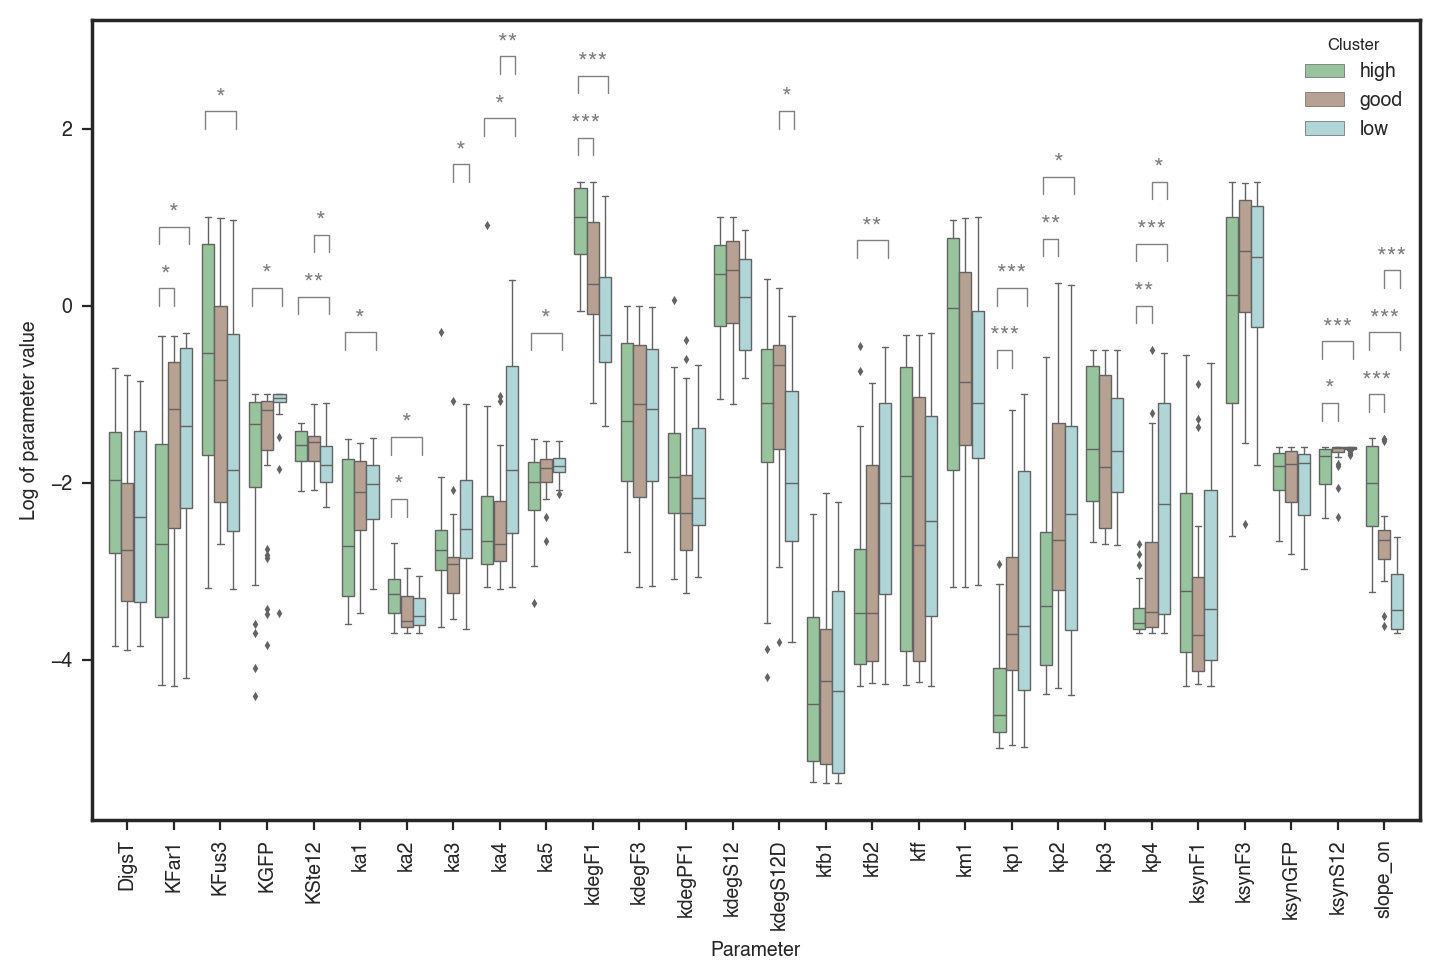

In [40]:
# plot box plot comparing parameter sets for dig^^

arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P 

box = ["#8FCC96", "#BD9F8D", "#AADBDC"]
sns.set_palette(box)

labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12','kdegS12D', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12', 'slope_on']

d = []
e = []
f = []

gd=0
hi=0
low=0

for i in range(len(arr_best_inds_P)):
    if dig_scores[i]==1:
        gd+=1
#         print(n)
        d.append({' ksynF3':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' kff':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' kdegPF1':np.log10(arr_best_inds_P[i][gen])[22], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[25],
                   ' slope_on':np.log10(arr_best_inds_P[i][gen])[26],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[27]})
    else:
        if high_low[i] == 'high':
            hi+=1
            e.append({' ksynF3':np.log10(arr_best_inds_P[i][gen])[0], 
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' kff':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[20], 
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
                   ' kdegPF1':np.log10(arr_best_inds_P[i][gen])[22], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[24], 
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[25],
                   ' slope_on':np.log10(arr_best_inds_P[i][gen])[26],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[27]})
        else:
            low+=1
            f.append({' ksynF3':np.log10(arr_best_inds_P[i][gen])[0], 
               ' kfb1':np.log10(arr_best_inds_P[i][gen])[1], 
               ' KFus3':np.log10(arr_best_inds_P[i][gen])[2], 
               ' kp1':np.log10(arr_best_inds_P[i][gen])[3], 
               ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
               ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
               ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
               ' kfb2':np.log10(arr_best_inds_P[i][gen])[7], 
               ' KSte12':np.log10(arr_best_inds_P[i][gen])[8],
               ' kdegS12':np.log10(arr_best_inds_P[i][gen])[9], 
               ' kff':np.log10(arr_best_inds_P[i][gen])[10], 
               ' km1':np.log10(arr_best_inds_P[i][gen])[11], 
               ' ka1':np.log10(arr_best_inds_P[i][gen])[12], 
               ' DigsT':np.log10(arr_best_inds_P[i][gen])[13], 
               ' ka2':np.log10(arr_best_inds_P[i][gen])[14], 
               ' ka3':np.log10(arr_best_inds_P[i][gen])[15], 
               ' ksynF1':np.log10(arr_best_inds_P[i][gen])[16], 
               ' ka5':np.log10(arr_best_inds_P[i][gen])[17], 
               ' KFar1':np.log10(arr_best_inds_P[i][gen])[18], 
               ' kp3':np.log10(arr_best_inds_P[i][gen])[19], 
               ' kp4':np.log10(arr_best_inds_P[i][gen])[20], 
               ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21],
               ' kdegPF1':np.log10(arr_best_inds_P[i][gen])[22], 
               ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[23], 
               ' ka4':np.log10(arr_best_inds_P[i][gen])[24], 
               ' KGFP':np.log10(arr_best_inds_P[i][gen])[25],
               ' slope_on':np.log10(arr_best_inds_P[i][gen])[26],
               ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[27]})
    

swarm_params_good = pd.DataFrame(d)
swarm_params_high = pd.DataFrame(e)
swarm_params_low = pd.DataFrame(f)

unstacked_good = swarm_params_good.unstack().reset_index() 
unstacked_good.columns = ['Parameter', 'index', 'Log of parameter value']

unstacked_high = swarm_params_high.unstack().reset_index() 
unstacked_high.columns = ['Parameter', 'index', 'Log of parameter value']

unstacked_low = swarm_params_low.unstack().reset_index() 
unstacked_low.columns = ['Parameter', 'index', 'Log of parameter value']

# Get p-valuses
p_vals_good_high = []
p_vals_good_low = []
p_vals_low_high = []
for i in swarm_params_good.columns:
    p_vals_good_high.append(stats.ttest_ind(swarm_params_good[i],swarm_params_high[i])[1])
    p_vals_good_low.append(stats.ttest_ind(swarm_params_good[i],swarm_params_low[i])[1])
    p_vals_low_high.append(stats.ttest_ind(swarm_params_low[i],swarm_params_high[i])[1])
    
# Create comparison data frame
compare = pd.concat([unstacked_high,unstacked_good, unstacked_low], keys=['high', 'good', 'low'])
compare = compare.reset_index();
compare = compare.rename(columns={'level_0':'Cluster'})

# Make a box plot comparing parameter sets
fig = plt.figure(figsize=(7.3, 5))
g=sns.boxplot(x="Parameter", y="Log of parameter value",
            hue="Cluster", data=compare,linewidth = 0.5, fliersize = 1);
p_vals = p_vals_good_high
for i in range(len(p_vals)):
    if p_vals[i] < 0.001/3:
        x1, x2 = i-.33, i   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Log of parameter value'].max()+0.3, 0.2, 'gray'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size = 9)
    elif p_vals[i] < 0.01/3:
        x1, x2 = i-.33, i   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Log of parameter value'].max()+0.3, 0.2, 'gray'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size = 9)
    elif p_vals[i] < 0.05/3:
        x1, x2 = i-.33, i   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Log of parameter value'].max()+0.3, 0.2, 'gray'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size = 9)
p_vals = p_vals_low_high
for i in range(len(p_vals)):
    if p_vals[i] < 0.001/3:
        x1, x2 = i-.33, i+0.33   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Log of parameter value'].max()+1.0, 0.2, 'gray'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size = 9)
    elif p_vals[i] < 0.01/3:
        x1, x2 = i-.33, i+0.33   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Log of parameter value'].max()+1.0, 0.2, 'gray'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size = 9)
    elif p_vals[i] < 0.05/3:
        x1, x2 = i-.33, i+0.33   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Log of parameter value'].max()+1.0, 0.2, 'gray'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size = 9)
p_vals = p_vals_good_low
for i in range(len(p_vals)):
    if p_vals[i] < 0.001/3:
        x1, x2 = i, i+0.33   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Log of parameter value'].max()+1.7, 0.2, 'gray'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size = 9)
    elif p_vals[i] < 0.01/3:
        x1, x2 = i, i+0.33   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Log of parameter value'].max()+1.7, 0.2, 'gray'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size = 9)
    elif p_vals[i] < 0.05/3:
        x1, x2 = i, i+0.33   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = compare[compare['Parameter']== swarm_params_good.columns[i]]['Log of parameter value'].max()+1.7, 0.2, 'gray'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size = 9)

# sns.despine(offset=10, trim=True)
g.set_xticklabels(labelnames,rotation=90);

fig.tight_layout()

fig.savefig('Figure S7.png',dpi = 600)

# Figure S2

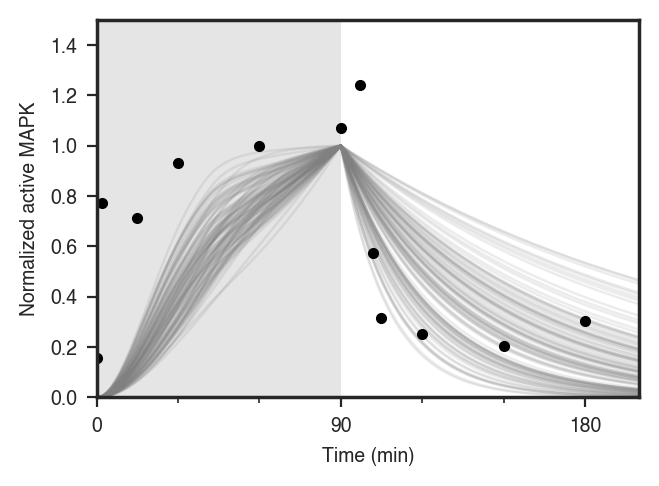

In [41]:
# MAPK Plots
arr_best_scores_P = onlyMAPK_best_scores_P
arr_end_scores_P = onlyMAPK_end_scores_P
arr_best_inds_P = onlyMAPK_best_inds_P
arrT_best_inds_P = onlyMAPKT_best_inds_P 

ppKss1 = np.array([0.21,0.90,0.79,0.89,0.85,0.87,0.99,0.33,0.18,0.26,0.20,0.28])*(1/0.85)
ppFus3 = np.array([0.05,0.37,0.38,0.62,0.76,0.85,1.00,0.58,0.32,0.15,0.13,0.21])*(1/0.76)
MAPK = np.average([ppKss1,ppFus3],axis=0)
MAPK_time = [0,2,15,30,60,90,97,102,105,120,150,180]

fig = plt.figure(figsize=(3.5,2.5))
gs = gridspec.GridSpec(1,1)
ax = fig.add_subplot(gs[0,0])

for j in range(len(arr_best_inds_P[:,gen])):
    for i in range(1):
        expX = 0
        ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
        curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
        ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
        odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
        SS=odes[100000,:]
        expX = simulate_singlepulse_experiment(curr_params, t1, 1,SS)
        norm = max(expX[:,0])
        col = 'gray'
        a = 0.15
        lw = 0.9
        # DIG DOUBLE DELETE
        if i == 0:
            curr_params = ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D
            ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D=curr_params
            odes = simulate_singlepulse_experiment(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_singlepulse_experiment(curr_params, t1, 90,SS)
            ax.plot(t1,expX[:,2]/expX[900,2],color=col,alpha=a,linewidth=lw)
ax.plot(MAPK_time,MAPK,'ko',markersize=3)
ax.set_xlim([0,200])
ax.xaxis.set_major_locator(plt.MultipleLocator(90))
ax.xaxis.set_minor_locator(plt.MultipleLocator(30))
ax.set_xlabel('Time (min)')
ax.set_ylabel('Normalized active MAPK')
ax.fill_between([0,90], 0, 1.75, facecolor='gray', alpha=0.2) 
ax.set_ylim([0,1.5])

fig.savefig('Figure S2.pdf',dpi=600)

# Persistance comparison figure (90 min stimulus)

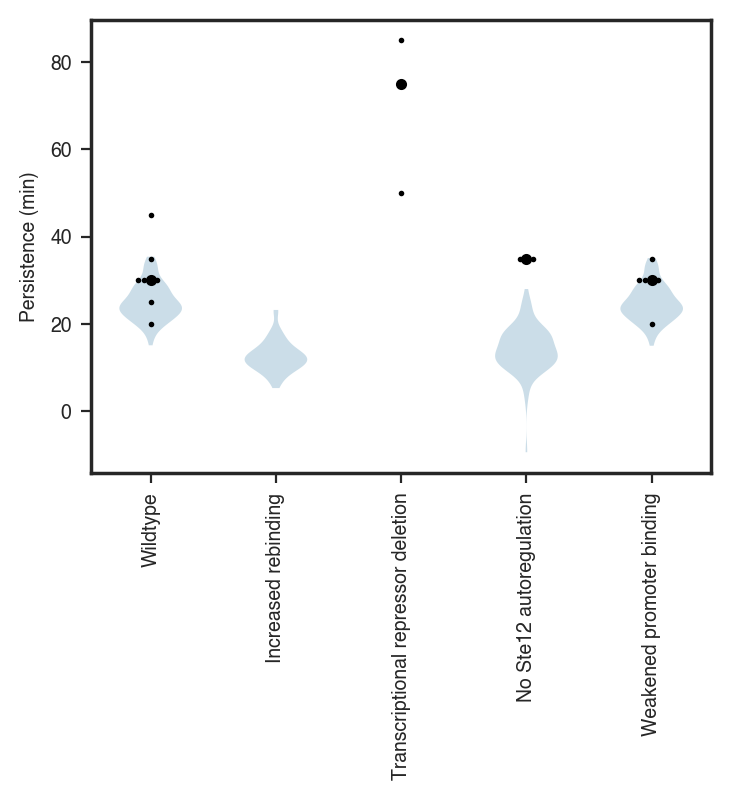

In [61]:
# Figure S8 (new)

# Calculate DIG memory change
dig_mem = []
wt_mem = []
bfb_mem = []
pre_mem = []
digslow_mem = []
for i in dig_max:
    dig_mem.append(float(t1[i]-90))
for i in digslow_max:
    digslow_mem.append(float(t1[i]-90))
for i in wt_max:
    wt_mem.append(float(t1[i]-90))
for i in bfb_max:
    bfb_mem.append(float(t1[i]-90))
for i in pre_max:
    pre_mem.append(float(t1[i]-90))

# First point is average, others are replicates
WT_per = [30, 30, 45, 20, 30, 25, 30, 35]
WT_loc = [0, 0.05, 0, 0, -0.05, 0, -0.1, 0]
BFB_per = [35,35, 35]
BFB_loc = [0, -0.05, 0.05]
PRE_per = [30,30,30,20,35,30]
PRE_loc = [0,0.05, -0.05, 0, 0, -0.1]
digDD_per = [75, 50, 85]
digDD_loc = [0,0,0]

axes = figure(figsize = [4, 3]).add_subplot(111)


plt.violinplot([wt_mem, dig_mem, 0, bfb_mem, pre_mem], showextrema=False);


for n,i in enumerate(WT_per):
    if n == 0:
        plt.plot(1,i,'ko',markersize = 3)
    else:
        plt.plot(1+WT_loc[n],i,'ko',markersize = 1)
for n,i in enumerate(BFB_per):
    if n == 0:
        plt.plot(4,i,'ko',markersize = 3)
    else:
        plt.plot(4+BFB_loc[n],i,'ko',markersize = 1)
for n,i in enumerate(PRE_per):
    if n == 0:
        plt.plot(5,i,'ko',markersize = 3)
    else:
        plt.plot(5+PRE_loc[n],i,'ko',markersize = 1)
for n,i in enumerate(digDD_per):
    if n == 0:
        plt.plot(3,i,'ko',markersize = 3)
    else:
        plt.plot(3+digDD_loc[n],i,'ko',markersize = 1)
        
plt.ylabel('Persistence (min)')


a=axes.get_xticks().tolist()
a[1]='Wildtype'
a[4]='No Ste12 autoregulation'
a[5]='Weakened promoter binding'
a[2]='Increased rebinding'
# a[3]='Decreased rebinding'
a[3]='Transcriptional repressor deletion'
plt.xticks(rotation='vertical')
axes.set_xticklabels(a);

# axes.set_ylim([0,90])

# Persistance calculation figure

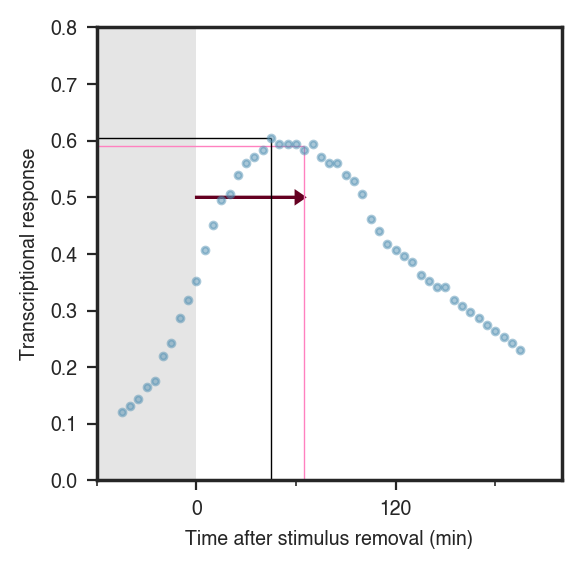

In [107]:
# plot
fig, ax = plt.subplots(figsize=(3,3))
dur = [45,60,75,90,160,200]
for i in [0]:
    plt.plot(times_50pulse[i]-dur[i],data_50pulse[i],marker='o',markersize=2.5,linestyle='None', color = "#5391B3", alpha = 0.5)
    plt.hlines(max(data_50pulse[i]),-60,45, lw = 0.5, color = "k")
    plt.hlines(max(data_50pulse[i])*.975,-60,65, lw = 0.5, color ="xkcd:pink")
    plt.vlines(65, 0, max(data_50pulse[i])*.975, lw = 0.5, color ="xkcd:pink")
    plt.vlines(45, 0, max(data_50pulse[i]), lw = 0.5, color ="k")
# plt.xlabel('Time after stimulus removal (min)')
plt.fill_between([-210,0], -5, 1.2, facecolor='gray', alpha=0.2)
plt.xlim([-60,220])
plt.ylim([0,0.8])
ax.xaxis.set_major_locator(plt.MultipleLocator(120))
ax.xaxis.set_minor_locator(plt.MultipleLocator(60))
plt.xlabel('Time after stimulus removal (min)')
plt.ylabel('Transcriptional response')
plt.arrow(0, 0.5, 60, 0, capstyle = 'projecting',head_width=0.02, head_length=5, fc='xkcd:maroon', ec='xkcd:maroon')
plt.savefig('S1.png',dpi=1200,bbox_extra_artists=(lgd,), bbox_inches='tight')

# Hill coefficient comparison

In [44]:
## HC1
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/varied hc/200623_hc1_100g500i10m50c/'
hc1_best_scores_P, hc1_end_scores_P, hc1_best_inds_P=load_data(directory,1.11) #1.0835
hc1T_best_inds_P = hc1_best_inds_P.transpose()

## HC3
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/varied hc/200620_hc3_100g500i10m50c/'
hc3_best_scores_P, hc3_end_scores_P, hc3_best_inds_P=load_data(directory,1.084) #1.0835
hc3T_best_inds_P = hc3_best_inds_P.transpose()


Loaded 9 files (out of 163) with cutoff score of 1.11
Loaded 10 files (out of 191) with cutoff score of 1.084


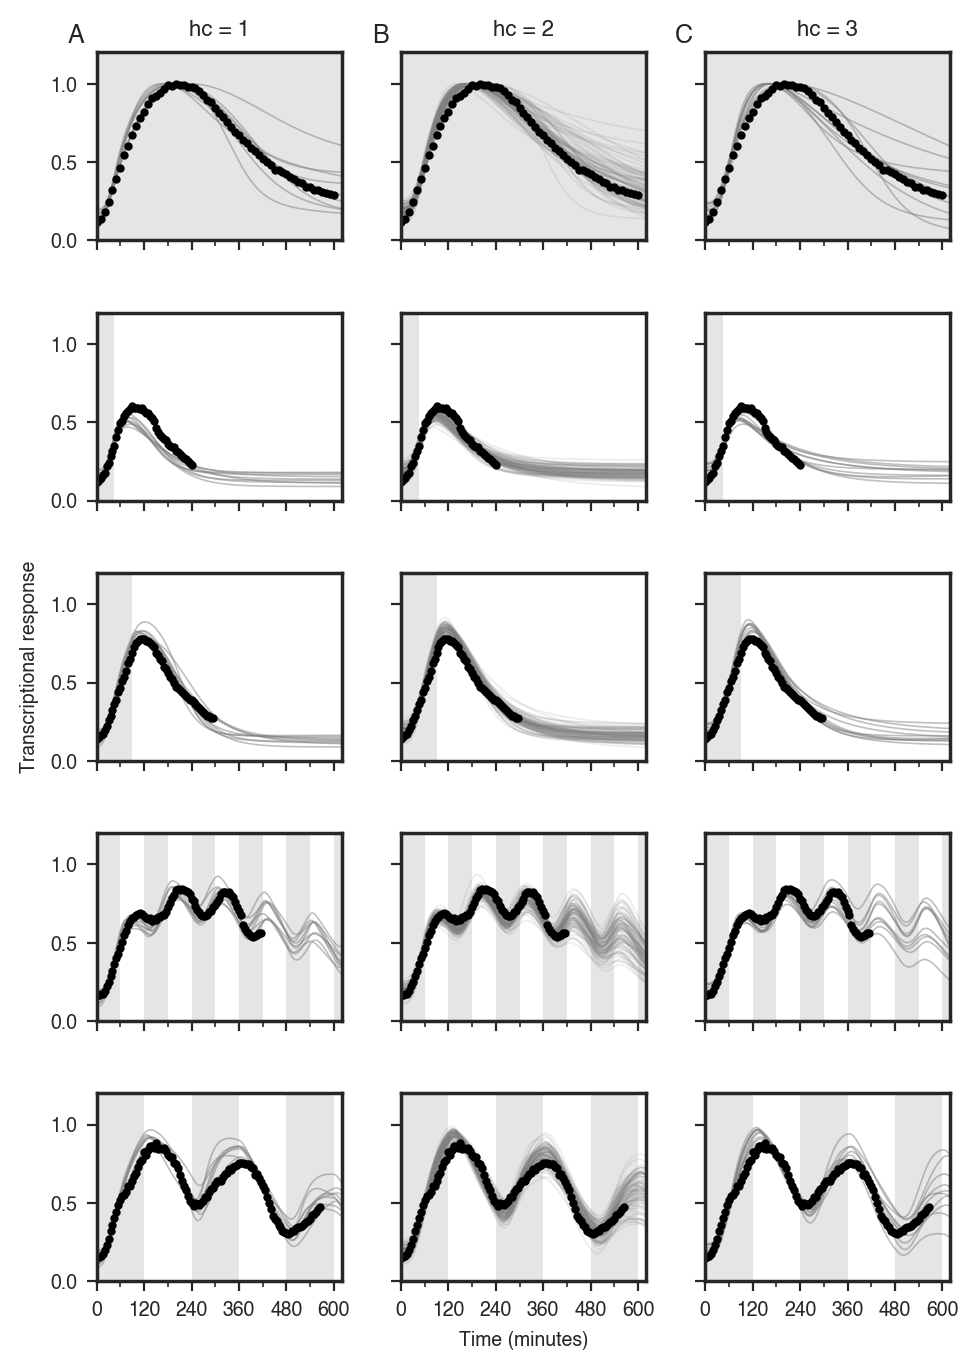

In [45]:
# Reviewer Figure 1
fig = plt.figure(figsize=(5.0,7.0))
gs = gridspec.GridSpec(5, 3)
gs.update(wspace=0.25, hspace=0.3) # set the spacing between axes.
A1 = fig.add_subplot(gs[0,0])
A2 = fig.add_subplot(gs[1,0])
A3 = fig.add_subplot(gs[2,0])
A4 = fig.add_subplot(gs[3,0])
A5 = fig.add_subplot(gs[4,0])
B1 = fig.add_subplot(gs[0,1])
B2 = fig.add_subplot(gs[1,1])
B3 = fig.add_subplot(gs[2,1])
B4 = fig.add_subplot(gs[3,1])
B5 = fig.add_subplot(gs[4,1])
C1 = fig.add_subplot(gs[0,2])
C2 = fig.add_subplot(gs[1,2])
C3 = fig.add_subplot(gs[2,2])
C4 = fig.add_subplot(gs[3,2])
C5 = fig.add_subplot(gs[4,2])
ax = fig.add_subplot(gs[0:2,:])

all_axes = [A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5]

label_axes = [A1, B1, C1]

for i, label in enumerate(('A','B', 'C')):
    ax_curr = label_axes[i]
    ax_curr.text(-0.05, 1.15, label, transform=ax_curr.transAxes,
      fontsize=9, va='top', ha='right')

for i in [ax]:
    i.spines['top'].set_color('none')
    i.spines['bottom'].set_color('none')
    i.spines['left'].set_color('none')
    i.spines['right'].set_color('none')
    i.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    i.set_facecolor('none')
    i.grid('off')
    i.axes.get_xaxis().set_visible(False)
    i.axes.get_yaxis().set_visible(False)

for i in [A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,C3,C4]:
    i.axes.set_xticklabels([])

for i in [B1,B2,B3,B4,B5,C1,C2,C3,C4,C5]:
    i.axes.set_yticklabels([])
    
for i in all_axes:
    i.xaxis.set_major_locator(plt.MultipleLocator(120))
    i.xaxis.set_minor_locator(plt.MultipleLocator(60))
    
A3.set_ylabel('Transcriptional response')
B5.set_xlabel('Time (minutes)')

A1.set_title('hc = 1',fontsize=8)
B1.set_title('hc = 2',fontsize=8)
C1.set_title('hc = 3',fontsize=8)

slope_off=0

# HC = 1
arr_best_scores_P = hc1_best_scores_P
arr_end_scores_P = hc1_end_scores_P
arr_best_inds_P = hc1_best_inds_P
arrT_best_inds_P = hc1T_best_inds_P 

hc = 1

time = np.linspace(0,620,621)
SS=[]
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    comp = max(expX[:,0])
    for i in [45,90]:
        expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 45:
            A2.plot(time, expX[:,0]/comp,color='gray',alpha=0.5,linewidth=0.6)
        else:
            A3.plot(time, expX[:,0]/comp,color='gray',alpha=0.5,linewidth=0.6)

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    comp = max(expX[:,0])
    for i in [120,240,1]:
        expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 120:
            A4.plot(time, expX[:,0]/comp,color='gray',alpha=0.5,linewidth=0.6)
        elif i == 240: 
            A5.plot(time, expX[:,0]/comp,color='gray',alpha=0.5,linewidth=0.6)
        else: 
            A1.plot(time, expX[:,0]/comp,color='gray',alpha=0.5,linewidth=0.6)
            
# HC = 2
arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P 

hc = 2

time = np.linspace(0,620,621)
SS=[]
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    comp = max(expX[:,0])
    for i in [45,90]:
        expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 45:
            B2.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        else:
            B3.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    comp = max(expX[:,0])
    for i in [120,240,1]:
        expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 120:
            B4.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        elif i == 240: 
            B5.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)
        else: 
            B1.plot(time, expX[:,0]/comp,color='gray',alpha=0.15,linewidth=0.6)

# HC = 3
arr_best_scores_P = hc3_best_scores_P
arr_end_scores_P = hc3_end_scores_P
arr_best_inds_P = hc3_best_inds_P
arrT_best_inds_P = hc3T_best_inds_P 

hc = 3

time = np.linspace(0,620,621)
SS=[]
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    comp = max(expX[:,0])
    for i in [45,90]:
        expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 45:
            C2.plot(time, expX[:,0]/comp,color='gray',alpha=0.5,linewidth=0.6)
        else:
            C3.plot(time, expX[:,0]/comp,color='gray',alpha=0.5,linewidth=0.6)

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    comp = max(expX[:,0])
    for i in [120,240,1]:
        expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 120:
            C4.plot(time, expX[:,0]/comp,color='gray',alpha=0.5,linewidth=0.6)
        elif i == 240: 
            C5.plot(time, expX[:,0]/comp,color='gray',alpha=0.5,linewidth=0.6)
        else: 
            C1.plot(time, expX[:,0]/comp,color='gray',alpha=0.5,linewidth=0.6)

scorefxn_time = times_50periodic
scorefxn_data = data_50periodic
for i in [A4,B4,C4]:
    i.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=2)
    i.axis([0, 620, 0, 1.2])
    for j in range(6):
        i.fill_between([j*120,j*120+60], 0, 1.2, facecolor='gray', alpha=0.2)
for i in [A5,B5,C5]:
    i.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=2)
    i.axis([0, 620, 0, 1.2])
    for j in range(4):
        i.fill_between([j*240,j*240+120], 0, 1.2, facecolor='gray', alpha=0.2)
        
scorefxn_time = times_50pulse
scorefxn_data = data_50pulse
for i in [A2,B2,C2]:
    i.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=2)
    i.axis([0, 620, 0, 1.2])
    i.fill_between([0,45], 0, 1.2, facecolor='gray', alpha=0.2)
for i in [A3,B3,C3]:
    i.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=2)
    i.axis([0, 620, 0, 1.2])
    i.fill_between([0,90], 0, 1.2, facecolor='gray', alpha=0.2)
    
for i in [A1,B1,C1]:
    i.plot(times_50constant[0], data_50constant[0], 'ko', markersize=2)
    i.axis([0, 620, 0, 1.2])
    i.fill_between([0,620], 0, 1.2, facecolor='gray', alpha=0.2)



gs.tight_layout(fig)

Text(0, 0.5, 'Density')

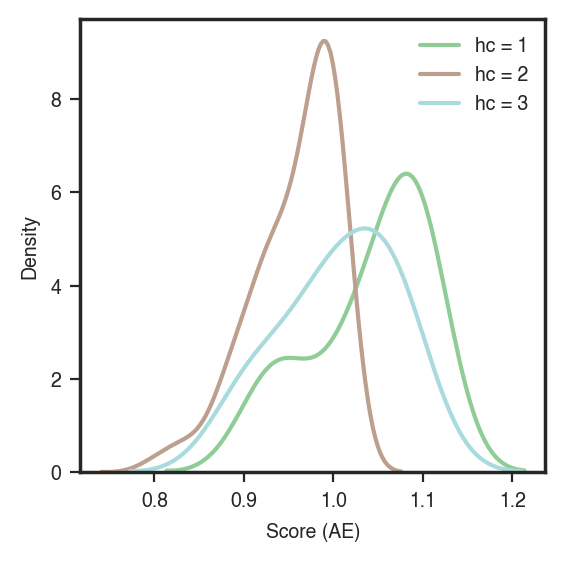

In [46]:
fig = plt.figure(figsize=(3.0,3.0))

sns.kdeplot(hc1_best_scores_P[:,100],label = 'hc = 1')
sns.kdeplot(all_best_scores_P[:,100],label = 'hc = 2')
sns.kdeplot(hc3_best_scores_P[:,100],label = 'hc = 3')

plt.xlabel('Score (AE)')
plt.ylabel('Density')